![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION


/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'
#target_location = 'São Paulo-SP-Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [14]:
run_sensitivity_analysis = True

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [15]:
# custom papermill parameters

In [16]:
# Parameters
target_location = "AC-Brazil"
infer_parameters_from_data = True
results_suffix = ".ac-brazil"
run_sensitivity_analysis = False


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [17]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [18]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [19]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
0,2019-12-31,Afghanistan,0,0,0,0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,38928341.0


Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [20]:
df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
#print(df_brazil_city_data.tail())

def aux_build_location(row):
    if not pd.isnull(row['city']):
        prefix = f"{row['city']}-"
    else:
        prefix = ""
    
    return prefix + f"{row['state']}-Brazil"

df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
df_brazil_city_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
51552,2020-02-27,SP-Brazil,0,0,1,0,45919049.0
51553,2020-02-26,São Paulo-SP-Brazil,0,0,1,0,12252023.0
51554,2020-02-26,SP-Brazil,0,0,1,0,45919049.0
51555,2020-02-25,São Paulo-SP-Brazil,1,0,1,0,12252023.0
51556,2020-02-25,SP-Brazil,1,0,1,0,45919049.0


In [21]:
df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
df_epidemy_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
941,2020-05-04,Lucas do Rio Verde-MT-Brazil,0,0,7,1,65534.0
942,2020-05-04,Mirassol d'Oeste-MT-Brazil,0,0,8,1,27739.0
943,2020-05-04,Nova Monte Verde-MT-Brazil,0,0,1,0,9178.0
925,2020-05-04,Alta Floresta-MT-Brazil,0,0,2,0,51782.0
292,2020-05-04,Acaraú-CE-Brazil,0,0,31,1,62641.0


Selecionemos apenas dados sobre o país de interesse.

In [22]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [23]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-04-07,3.595084
2020-04-08,3.595084
2020-04-09,3.595084
2020-04-10,3.595084
2020-04-11,3.595084


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,50,1,404,19,881935.0,NaN,6060,NaN
2020-05-01,83,0,487,19,881935.0,NaN,7305,NaN
2020-05-02,66,3,553,22,881935.0,NaN,8295,NaN
2020-05-03,105,3,658,25,881935.0,NaN,9870,NaN
2020-05-04,0,0,658,25,881935.0,NaN,9870,NaN


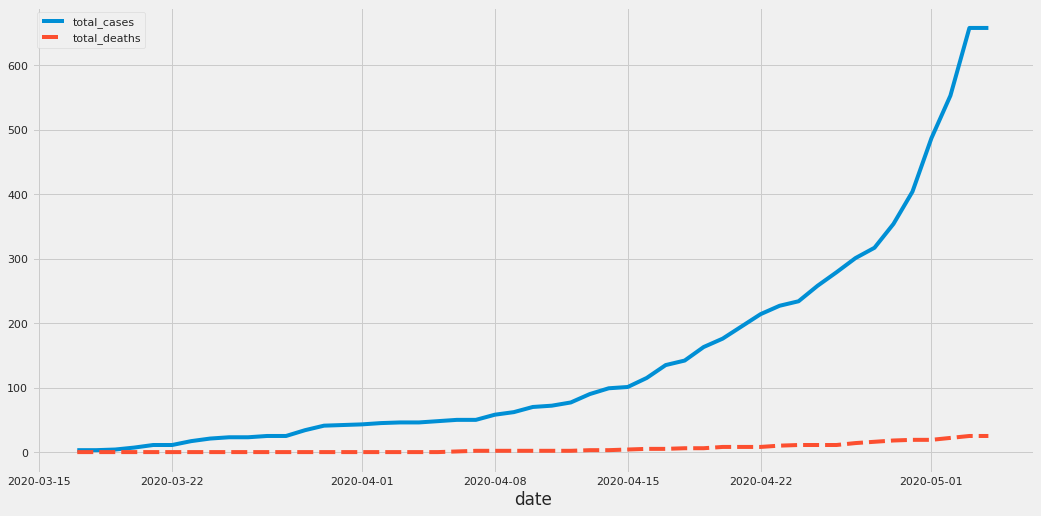

In [24]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

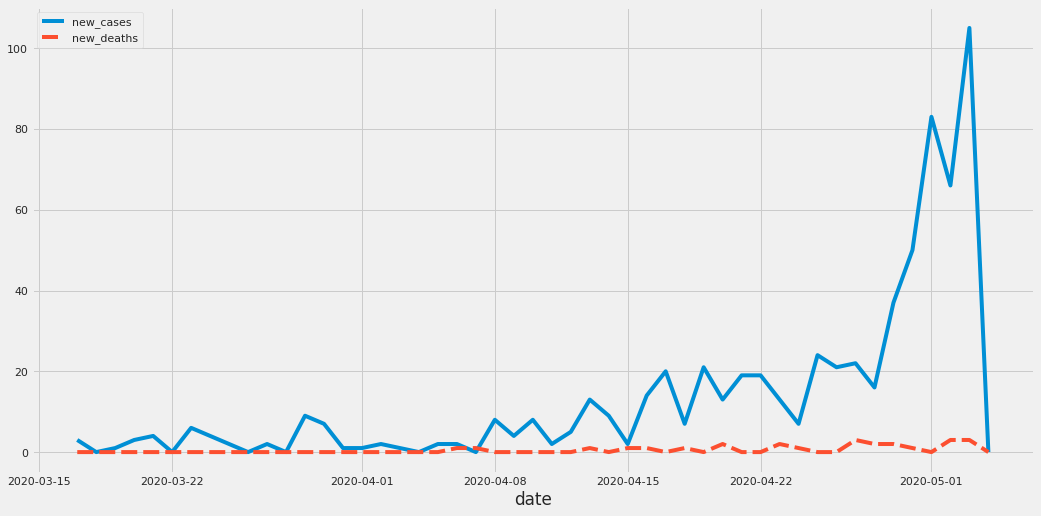

In [25]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [26]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-04-06 00:00:00')

In [27]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-04-06 00:00:00, population_size=881935.0, initially_infected=750.0


Filtremos os dados a partir da data de interesse.

In [28]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [29]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [30]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [31]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [32]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [33]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [34]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [35]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [36]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [37]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [38]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [39]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [40]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-06,881185.000000,750.000000,0.000000,0.000000,0.000000,0.000000,0.000000,750.000000,750.000000
2020-04-07,881185.000000,75.000000,0.000000,675.000000,675.000000,0.000000,0.000000,750.000000,750.000000
2020-04-08,880645.459218,547.040782,539.540782,540.000000,67.500000,202.500000,202.500000,1087.040782,1289.540782
2020-04-09,880214.090876,486.072420,431.368342,870.336704,492.336704,364.500000,162.000000,1356.409124,1720.909124
2020-04-10,879519.180134,743.517983,694.910741,1046.700871,437.465178,625.601011,261.101011,1790.218854,2415.819866


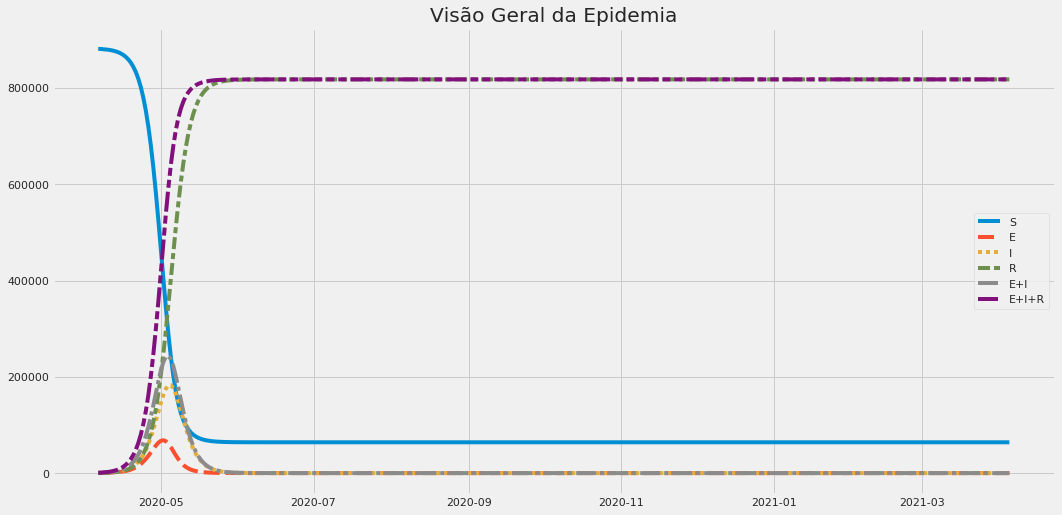

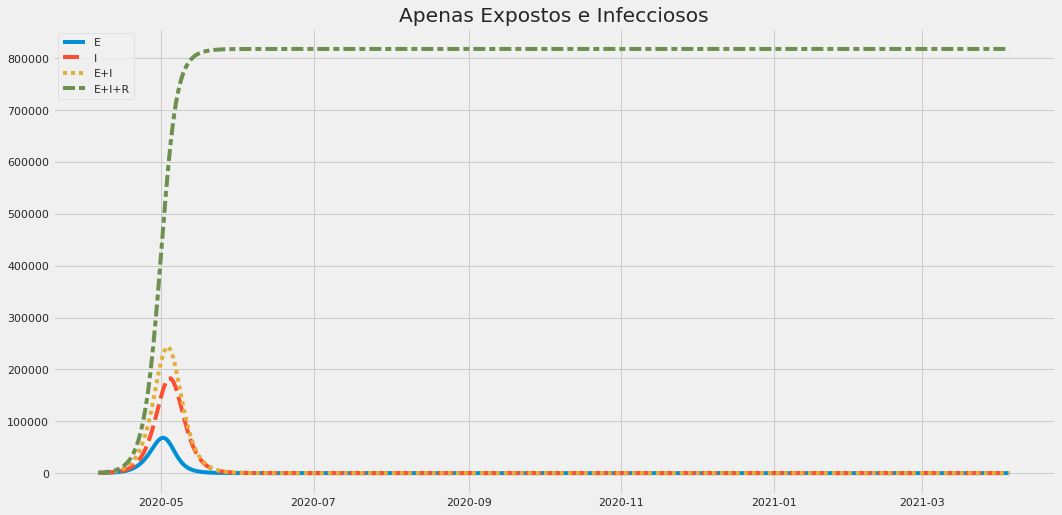

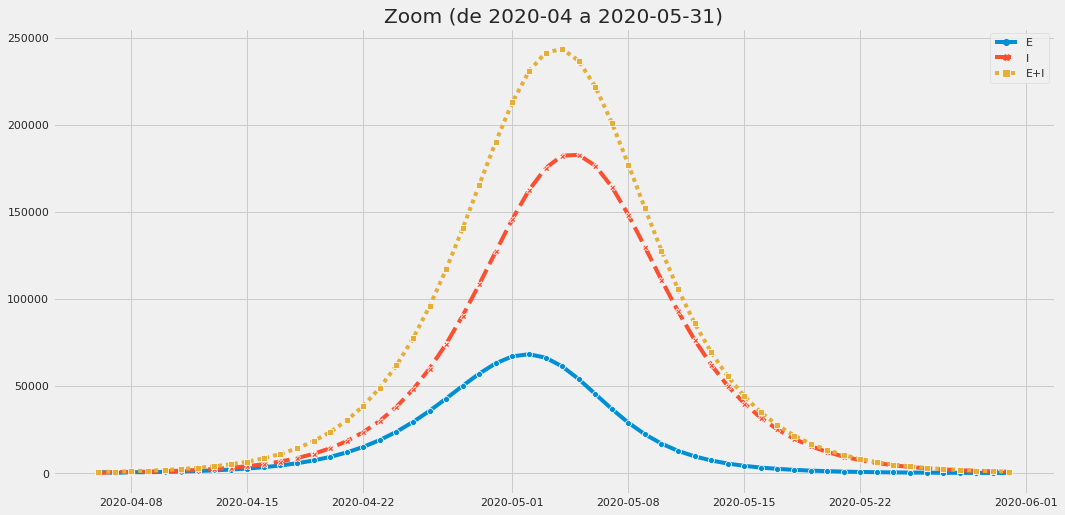

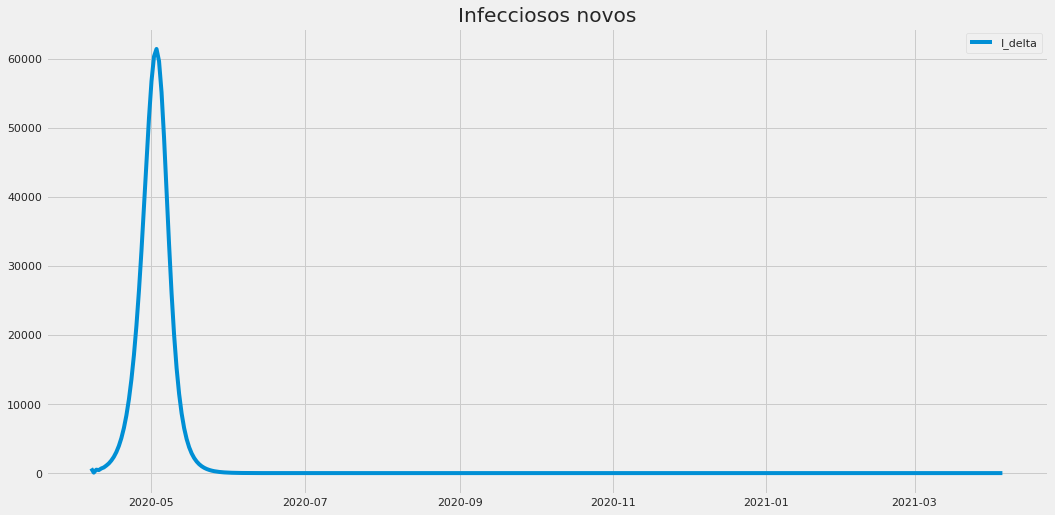

<Figure size 1152x576 with 0 Axes>

In [41]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

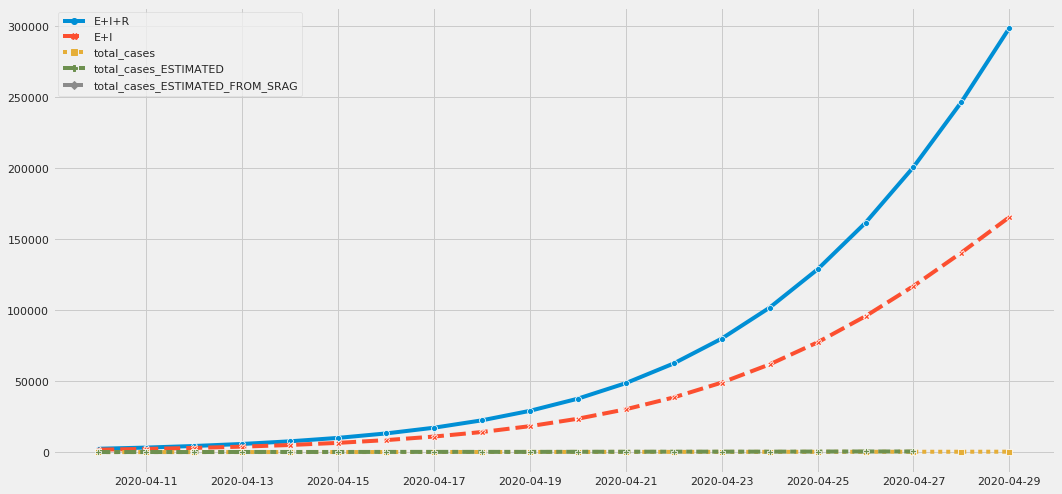

In [42]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [43]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-06,881185.000000,750.000000,0.000000,0.000000,0.000000,0.000000,0.000000,750.000000,750.000000
2020-04-07,881185.000000,0.000000,0.000000,750.000000,750.000000,0.000000,0.000000,750.000000,750.000000
2020-04-08,880510.574022,674.425978,674.425978,450.000000,0.000000,300.000000,300.000000,1124.425978,1424.425978
2020-04-09,880106.228143,404.345879,404.345879,944.425978,674.425978,480.000000,180.000000,1348.771857,1828.771857
2020-04-10,879258.007280,848.220863,848.220863,971.001466,404.345879,857.770391,377.770391,1819.222329,2676.992720


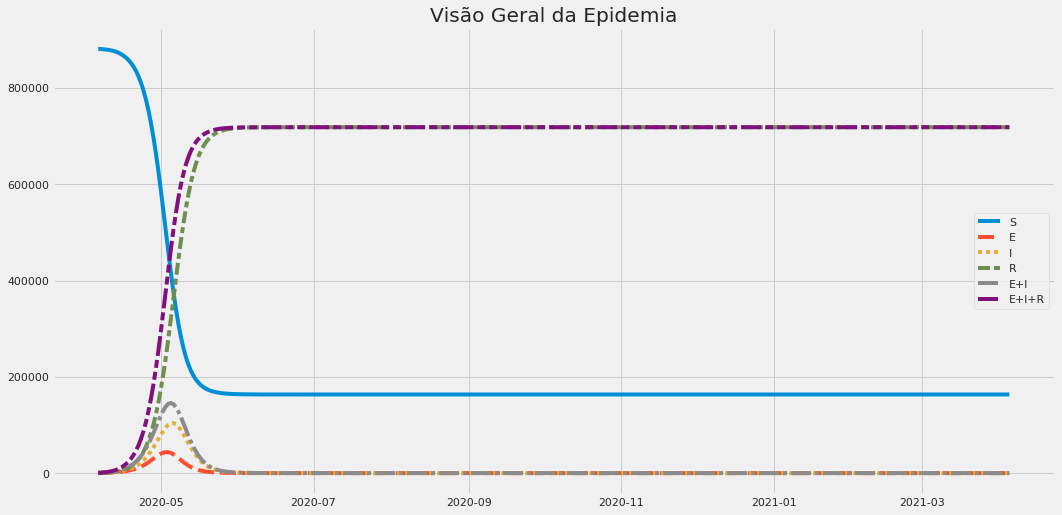

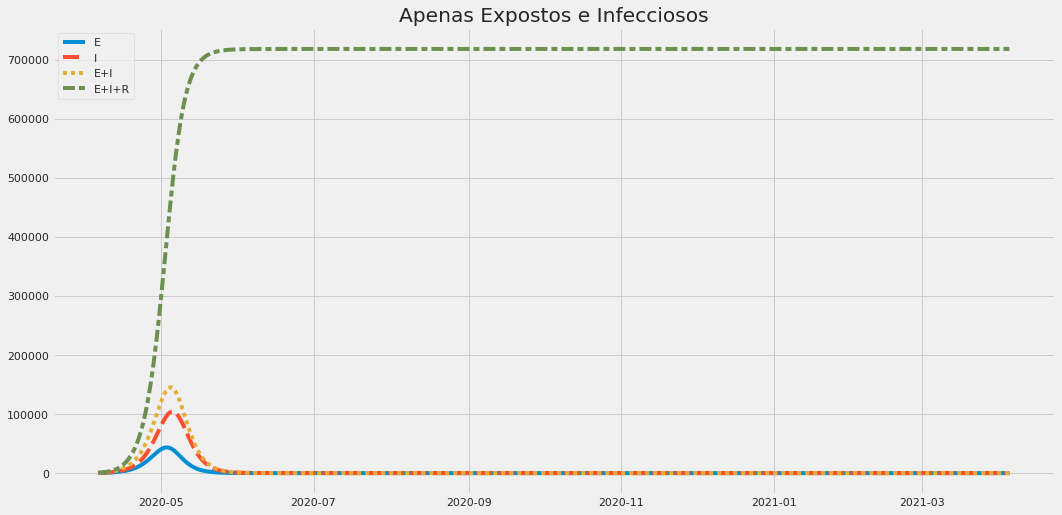

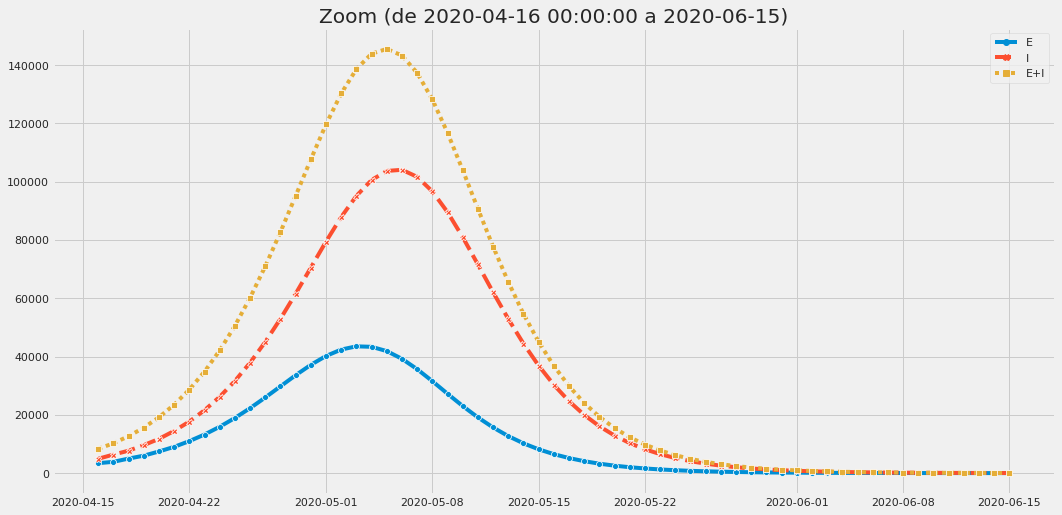

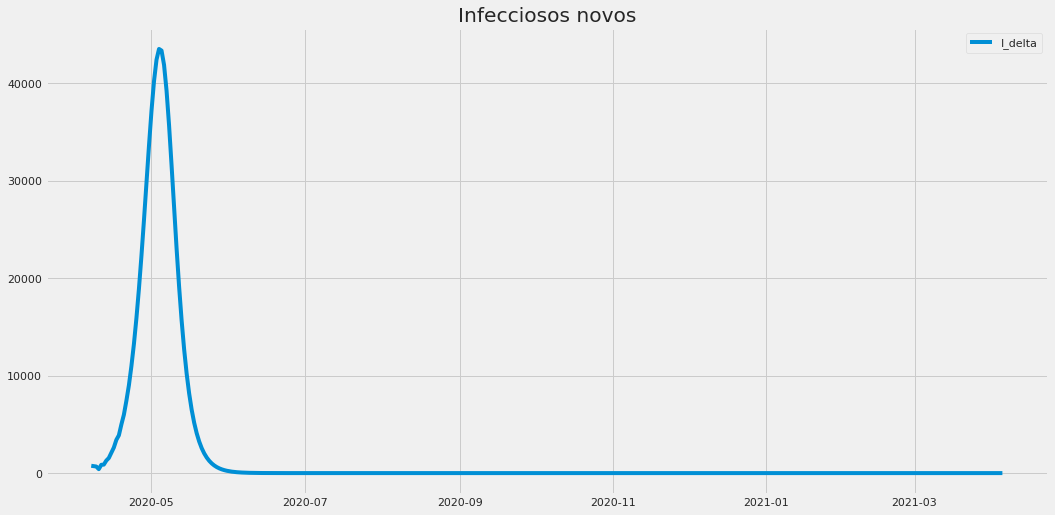

<Figure size 1152x576 with 0 Axes>

In [44]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

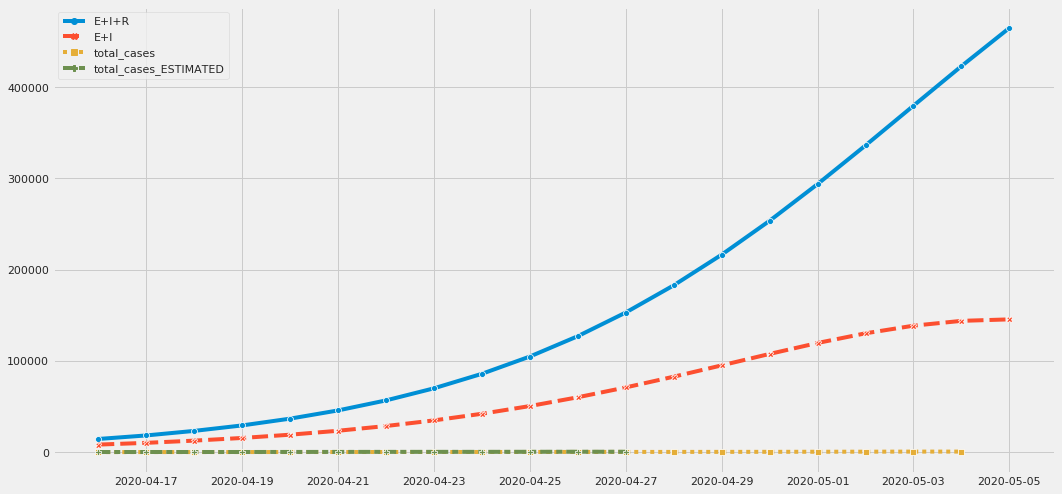

In [45]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [46]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [47]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

  1%|          | 12/1000 [00:00<00:08, 119.40trial/s, best loss: 340.0254613932059]

  2%|▏         | 23/1000 [00:00<00:08, 116.19trial/s, best loss: 80.9746201641844] 

  3%|▎         | 31/1000 [00:00<00:09, 99.42trial/s, best loss: 80.9746201641844] 

  4%|▍         | 38/1000 [00:00<00:10, 88.21trial/s, best loss: 80.9746201641844]

  5%|▍         | 47/1000 [00:00<00:10, 87.17trial/s, best loss: 64.80312407685484]

  6%|▌         | 56/1000 [00:00<00:10, 86.27trial/s, best loss: 64.80312407685484]

  6%|▋         | 64/1000 [00:00<00:11, 82.97trial/s, best loss: 64.80312407685484]

  7%|▋         | 72/1000 [00:00<00:11, 78.41trial/s, best loss: 64.80312407685484]

  8%|▊         | 80/1000 [00:00<00:11, 77.30trial/s, best loss: 64.80312407685484]

  9%|▉         | 88/1000 [00:01<00:12, 75.22trial/s, best loss: 64.80312407685484]

 10%|▉         | 96/1000 [00:01<00:12, 74.80trial/s, best loss: 64.80312407685484]

 10%|█         | 104/1000 [00:01<00:12, 74.24trial/s, best loss: 64.80312407685484]

 11%|█         | 112/1000 [00:01<00:11, 74.71trial/s, best loss: 64.80312407685484]

 12%|█▏        | 120/1000 [00:01<00:11, 74.75trial/s, best loss: 64.80312407685484]

 13%|█▎        | 128/1000 [00:01<00:11, 73.54trial/s, best loss: 64.80312407685484]

 14%|█▎        | 136/1000 [00:01<00:11, 73.50trial/s, best loss: 64.80312407685484]

 14%|█▍        | 144/1000 [00:01<00:12, 69.78trial/s, best loss: 64.80312407685484]

 15%|█▌        | 153/1000 [00:01<00:11, 73.61trial/s, best loss: 55.19518478091056]

 16%|█▌        | 161/1000 [00:02<00:11, 72.44trial/s, best loss: 55.19518478091056]

 17%|█▋        | 169/1000 [00:02<00:11, 69.67trial/s, best loss: 55.19518478091056]

 18%|█▊        | 177/1000 [00:02<00:11, 69.65trial/s, best loss: 55.19518478091056]

 18%|█▊        | 185/1000 [00:02<00:11, 69.52trial/s, best loss: 55.19518478091056]

 19%|█▉        | 192/1000 [00:02<00:11, 69.30trial/s, best loss: 55.19518478091056]

 20%|██        | 200/1000 [00:02<00:11, 71.99trial/s, best loss: 55.19518478091056]

 21%|██        | 208/1000 [00:02<00:10, 74.07trial/s, best loss: 55.19518478091056]

 22%|██▏       | 216/1000 [00:02<00:10, 73.11trial/s, best loss: 55.19518478091056]

 22%|██▏       | 224/1000 [00:02<00:10, 74.64trial/s, best loss: 55.19518478091056]

 23%|██▎       | 232/1000 [00:03<00:10, 74.22trial/s, best loss: 55.19518478091056]

 24%|██▍       | 240/1000 [00:03<00:10, 75.60trial/s, best loss: 55.19518478091056]

 25%|██▍       | 248/1000 [00:03<00:09, 76.45trial/s, best loss: 55.19518478091056]

 26%|██▌       | 256/1000 [00:03<00:09, 76.97trial/s, best loss: 55.19518478091056]

 26%|██▋       | 264/1000 [00:03<00:09, 77.31trial/s, best loss: 55.19518478091056]

 27%|██▋       | 272/1000 [00:03<00:09, 77.38trial/s, best loss: 37.729633382877736]

 28%|██▊       | 280/1000 [00:03<00:09, 76.49trial/s, best loss: 37.729633382877736]

 29%|██▉       | 288/1000 [00:03<00:09, 73.32trial/s, best loss: 37.729633382877736]

 30%|██▉       | 296/1000 [00:03<00:09, 74.05trial/s, best loss: 37.729633382877736]

 30%|███       | 304/1000 [00:03<00:09, 73.85trial/s, best loss: 37.729633382877736]

 31%|███       | 312/1000 [00:04<00:09, 73.83trial/s, best loss: 37.729633382877736]

 32%|███▏      | 320/1000 [00:04<00:09, 74.07trial/s, best loss: 37.729633382877736]

 33%|███▎      | 328/1000 [00:04<00:09, 73.94trial/s, best loss: 37.729633382877736]

 34%|███▎      | 336/1000 [00:04<00:09, 73.71trial/s, best loss: 37.729633382877736]

 34%|███▍      | 344/1000 [00:04<00:08, 73.63trial/s, best loss: 37.729633382877736]

 35%|███▌      | 352/1000 [00:04<00:09, 71.56trial/s, best loss: 37.729633382877736]

 36%|███▌      | 360/1000 [00:04<00:09, 67.38trial/s, best loss: 37.729633382877736]

 37%|███▋      | 367/1000 [00:04<00:09, 67.46trial/s, best loss: 37.729633382877736]

 37%|███▋      | 374/1000 [00:05<00:09, 66.80trial/s, best loss: 37.729633382877736]

 38%|███▊      | 381/1000 [00:05<00:10, 58.32trial/s, best loss: 37.729633382877736]

 39%|███▉      | 388/1000 [00:05<00:10, 61.06trial/s, best loss: 37.729633382877736]

 40%|███▉      | 395/1000 [00:05<00:09, 62.65trial/s, best loss: 37.729633382877736]

 40%|████      | 402/1000 [00:05<00:09, 61.81trial/s, best loss: 37.729633382877736]

 41%|████      | 409/1000 [00:05<00:09, 60.54trial/s, best loss: 37.729633382877736]

 42%|████▏     | 416/1000 [00:05<00:09, 60.59trial/s, best loss: 37.729633382877736]

 42%|████▏     | 423/1000 [00:05<00:09, 59.63trial/s, best loss: 37.729633382877736]

 43%|████▎     | 430/1000 [00:05<00:09, 61.08trial/s, best loss: 37.729633382877736]

 44%|████▎     | 437/1000 [00:06<00:10, 54.08trial/s, best loss: 37.729633382877736]

 44%|████▍     | 443/1000 [00:06<00:10, 51.01trial/s, best loss: 37.729633382877736]

 45%|████▍     | 449/1000 [00:06<00:10, 53.06trial/s, best loss: 37.729633382877736]

 46%|████▌     | 455/1000 [00:06<00:10, 54.23trial/s, best loss: 37.729633382877736]

 46%|████▌     | 461/1000 [00:06<00:09, 54.50trial/s, best loss: 37.729633382877736]

 47%|████▋     | 467/1000 [00:06<00:09, 55.59trial/s, best loss: 37.729633382877736]

 47%|████▋     | 473/1000 [00:06<00:09, 52.96trial/s, best loss: 37.729633382877736]

 48%|████▊     | 479/1000 [00:06<00:09, 54.15trial/s, best loss: 37.729633382877736]

 48%|████▊     | 485/1000 [00:07<00:09, 54.57trial/s, best loss: 37.729633382877736]

 49%|████▉     | 491/1000 [00:07<00:09, 53.87trial/s, best loss: 37.729633382877736]

 50%|████▉     | 498/1000 [00:07<00:08, 56.34trial/s, best loss: 37.729633382877736]

 50%|█████     | 505/1000 [00:07<00:08, 57.68trial/s, best loss: 37.729633382877736]

 51%|█████     | 511/1000 [00:07<00:08, 57.48trial/s, best loss: 37.729633382877736]

 52%|█████▏    | 518/1000 [00:07<00:08, 58.41trial/s, best loss: 37.729633382877736]

 52%|█████▏    | 524/1000 [00:07<00:08, 58.77trial/s, best loss: 37.729633382877736]

 53%|█████▎    | 530/1000 [00:07<00:08, 57.47trial/s, best loss: 37.729633382877736]

 54%|█████▎    | 537/1000 [00:07<00:07, 58.25trial/s, best loss: 37.729633382877736]

 54%|█████▍    | 543/1000 [00:07<00:07, 58.13trial/s, best loss: 37.729633382877736]

 55%|█████▍    | 549/1000 [00:08<00:07, 58.07trial/s, best loss: 37.729633382877736]

 56%|█████▌    | 555/1000 [00:08<00:07, 57.03trial/s, best loss: 37.729633382877736]

 56%|█████▌    | 561/1000 [00:08<00:07, 57.77trial/s, best loss: 37.729633382877736]

 57%|█████▋    | 567/1000 [00:08<00:07, 57.44trial/s, best loss: 37.729633382877736]

 57%|█████▋    | 573/1000 [00:08<00:07, 58.06trial/s, best loss: 37.729633382877736]

 58%|█████▊    | 579/1000 [00:08<00:07, 58.20trial/s, best loss: 37.729633382877736]

 58%|█████▊    | 585/1000 [00:08<00:07, 55.28trial/s, best loss: 37.729633382877736]

 59%|█████▉    | 591/1000 [00:08<00:07, 52.50trial/s, best loss: 37.729633382877736]

 60%|█████▉    | 597/1000 [00:09<00:08, 49.44trial/s, best loss: 37.729633382877736]

 60%|██████    | 603/1000 [00:09<00:08, 48.84trial/s, best loss: 37.729633382877736]

 61%|██████    | 609/1000 [00:09<00:07, 51.26trial/s, best loss: 37.729633382877736]

 62%|██████▏   | 615/1000 [00:09<00:07, 52.83trial/s, best loss: 37.729633382877736]

 62%|██████▏   | 621/1000 [00:09<00:07, 53.73trial/s, best loss: 37.729633382877736]

 63%|██████▎   | 627/1000 [00:09<00:06, 54.82trial/s, best loss: 37.729633382877736]

 63%|██████▎   | 633/1000 [00:09<00:06, 52.95trial/s, best loss: 37.729633382877736]

 64%|██████▍   | 639/1000 [00:09<00:06, 52.56trial/s, best loss: 37.729633382877736]

 64%|██████▍   | 645/1000 [00:09<00:07, 49.61trial/s, best loss: 37.729633382877736]

 65%|██████▌   | 651/1000 [00:10<00:07, 48.77trial/s, best loss: 37.729633382877736]

 66%|██████▌   | 656/1000 [00:10<00:07, 48.72trial/s, best loss: 37.729633382877736]

 66%|██████▌   | 662/1000 [00:10<00:06, 49.35trial/s, best loss: 37.729633382877736]

 67%|██████▋   | 668/1000 [00:10<00:06, 50.81trial/s, best loss: 37.729633382877736]

 67%|██████▋   | 674/1000 [00:10<00:06, 50.28trial/s, best loss: 37.729633382877736]

 68%|██████▊   | 680/1000 [00:10<00:06, 50.18trial/s, best loss: 37.729633382877736]

 69%|██████▊   | 686/1000 [00:10<00:06, 46.90trial/s, best loss: 37.729633382877736]

 69%|██████▉   | 691/1000 [00:10<00:06, 45.28trial/s, best loss: 37.729633382877736]

 70%|██████▉   | 696/1000 [00:11<00:06, 45.39trial/s, best loss: 37.729633382877736]

 70%|███████   | 701/1000 [00:11<00:06, 44.47trial/s, best loss: 37.729633382877736]

 71%|███████   | 706/1000 [00:11<00:06, 44.34trial/s, best loss: 37.729633382877736]

 71%|███████   | 711/1000 [00:11<00:06, 44.83trial/s, best loss: 37.729633382877736]

 72%|███████▏  | 716/1000 [00:11<00:06, 45.04trial/s, best loss: 37.729633382877736]

 72%|███████▏  | 722/1000 [00:11<00:05, 47.02trial/s, best loss: 37.729633382877736]

 73%|███████▎  | 727/1000 [00:11<00:06, 43.07trial/s, best loss: 37.729633382877736]

 73%|███████▎  | 732/1000 [00:11<00:06, 42.96trial/s, best loss: 37.729633382877736]

 74%|███████▎  | 737/1000 [00:11<00:06, 38.94trial/s, best loss: 37.729633382877736]

 74%|███████▍  | 742/1000 [00:12<00:06, 37.41trial/s, best loss: 37.729633382877736]

 75%|███████▍  | 748/1000 [00:12<00:06, 40.45trial/s, best loss: 37.729633382877736]

 75%|███████▌  | 754/1000 [00:12<00:05, 43.13trial/s, best loss: 37.729633382877736]

 76%|███████▌  | 759/1000 [00:12<00:05, 44.51trial/s, best loss: 37.729633382877736]

 76%|███████▋  | 764/1000 [00:12<00:05, 44.05trial/s, best loss: 37.729633382877736]

 77%|███████▋  | 769/1000 [00:12<00:05, 44.29trial/s, best loss: 37.729633382877736]

 77%|███████▋  | 774/1000 [00:12<00:05, 37.84trial/s, best loss: 37.729633382877736]

 78%|███████▊  | 779/1000 [00:13<00:05, 38.06trial/s, best loss: 37.729633382877736]

 78%|███████▊  | 783/1000 [00:13<00:05, 37.59trial/s, best loss: 37.729633382877736]

 79%|███████▉  | 788/1000 [00:13<00:05, 40.08trial/s, best loss: 37.729633382877736]

 79%|███████▉  | 793/1000 [00:13<00:04, 42.22trial/s, best loss: 37.729633382877736]

 80%|███████▉  | 798/1000 [00:13<00:04, 42.70trial/s, best loss: 37.729633382877736]

 80%|████████  | 803/1000 [00:13<00:04, 42.72trial/s, best loss: 37.729633382877736]

 81%|████████  | 808/1000 [00:13<00:05, 37.89trial/s, best loss: 37.729633382877736]

 81%|████████  | 812/1000 [00:13<00:05, 33.35trial/s, best loss: 37.729633382877736]

 82%|████████▏ | 816/1000 [00:13<00:05, 35.03trial/s, best loss: 37.729633382877736]

 82%|████████▏ | 820/1000 [00:14<00:05, 33.19trial/s, best loss: 37.729633382877736]

 82%|████████▎ | 825/1000 [00:14<00:04, 36.20trial/s, best loss: 37.729633382877736]

 83%|████████▎ | 830/1000 [00:14<00:04, 37.56trial/s, best loss: 37.729633382877736]

 83%|████████▎ | 834/1000 [00:14<00:04, 37.83trial/s, best loss: 37.729633382877736]

 84%|████████▍ | 839/1000 [00:14<00:04, 37.83trial/s, best loss: 37.729633382877736]

 84%|████████▍ | 843/1000 [00:14<00:04, 34.43trial/s, best loss: 37.729633382877736]

 85%|████████▍ | 847/1000 [00:14<00:04, 34.90trial/s, best loss: 37.729633382877736]

 85%|████████▌ | 852/1000 [00:14<00:03, 37.45trial/s, best loss: 37.729633382877736]

 86%|████████▌ | 857/1000 [00:15<00:03, 38.99trial/s, best loss: 37.729633382877736]

 86%|████████▌ | 861/1000 [00:15<00:03, 38.76trial/s, best loss: 37.729633382877736]

 87%|████████▋ | 866/1000 [00:15<00:03, 35.25trial/s, best loss: 37.729633382877736]

 87%|████████▋ | 871/1000 [00:15<00:03, 36.48trial/s, best loss: 37.729633382877736]

 88%|████████▊ | 876/1000 [00:15<00:03, 37.15trial/s, best loss: 37.729633382877736]

 88%|████████▊ | 880/1000 [00:15<00:03, 37.66trial/s, best loss: 37.729633382877736]

 88%|████████▊ | 884/1000 [00:15<00:03, 37.86trial/s, best loss: 37.729633382877736]

 89%|████████▉ | 888/1000 [00:15<00:03, 37.29trial/s, best loss: 37.729633382877736]

 89%|████████▉ | 892/1000 [00:16<00:02, 37.02trial/s, best loss: 37.729633382877736]

 90%|████████▉ | 896/1000 [00:16<00:02, 37.26trial/s, best loss: 37.729633382877736]

 90%|█████████ | 900/1000 [00:16<00:02, 36.88trial/s, best loss: 37.729633382877736]

 90%|█████████ | 904/1000 [00:16<00:02, 36.83trial/s, best loss: 35.25027769446163] 

 91%|█████████ | 908/1000 [00:16<00:02, 37.34trial/s, best loss: 35.25027769446163]

 91%|█████████ | 912/1000 [00:16<00:02, 36.19trial/s, best loss: 35.25027769446163]

 92%|█████████▏| 916/1000 [00:16<00:02, 36.60trial/s, best loss: 35.25027769446163]

 92%|█████████▏| 920/1000 [00:16<00:02, 34.29trial/s, best loss: 35.25027769446163]

 92%|█████████▏| 924/1000 [00:16<00:02, 35.00trial/s, best loss: 35.25027769446163]

 93%|█████████▎| 928/1000 [00:17<00:02, 35.50trial/s, best loss: 35.25027769446163]

 93%|█████████▎| 932/1000 [00:17<00:01, 35.50trial/s, best loss: 35.25027769446163]

 94%|█████████▎| 936/1000 [00:17<00:01, 35.29trial/s, best loss: 35.25027769446163]

 94%|█████████▍| 940/1000 [00:17<00:01, 35.14trial/s, best loss: 35.25027769446163]

 94%|█████████▍| 945/1000 [00:17<00:01, 36.76trial/s, best loss: 35.25027769446163]

 95%|█████████▌| 950/1000 [00:17<00:01, 38.36trial/s, best loss: 35.25027769446163]

 96%|█████████▌| 955/1000 [00:17<00:01, 39.53trial/s, best loss: 35.25027769446163]

 96%|█████████▌| 959/1000 [00:17<00:01, 38.51trial/s, best loss: 35.25027769446163]

 96%|█████████▋| 964/1000 [00:17<00:00, 39.70trial/s, best loss: 35.25027769446163]

 97%|█████████▋| 968/1000 [00:18<00:00, 38.97trial/s, best loss: 35.25027769446163]

 97%|█████████▋| 973/1000 [00:18<00:00, 40.16trial/s, best loss: 35.25027769446163]

 98%|█████████▊| 978/1000 [00:18<00:00, 41.16trial/s, best loss: 35.25027769446163]

 98%|█████████▊| 983/1000 [00:18<00:00, 41.27trial/s, best loss: 35.25027769446163]

 99%|█████████▉| 988/1000 [00:18<00:00, 41.38trial/s, best loss: 35.25027769446163]

 99%|█████████▉| 993/1000 [00:18<00:00, 41.81trial/s, best loss: 35.25027769446163]

100%|█████████▉| 998/1000 [00:18<00:00, 40.56trial/s, best loss: 35.25027769446163]

100%|██████████| 1000/1000 [00:18<00:00, 53.14trial/s, best loss: 35.25027769446163]


Best parameters found: {'alpha': 0.9971732259866345, 'beta': 0.11145898551035649, 'gamma': 5.507240996241794e-05}


In [48]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-06,881185.000000,750.000000,0.000000,0.000000,0.000000,0.000000,0.000000,750.000000,750.000000
2020-04-07,881185.000000,2.120081,0.000000,747.879919,747.879919,0.000000,0.000000,750.000000,750.000000
2020-04-08,881101.712951,83.293042,83.287049,749.952819,2.114088,0.041188,0.041188,833.245862,833.287049
2020-04-09,881018.202948,83.745453,83.510002,832.969109,83.057592,0.082489,0.041302,916.714562,916.797052
2020-04-10,880925.457568,92.982110,92.745380,916.431959,83.508723,0.128363,0.045874,1009.414069,1009.542432


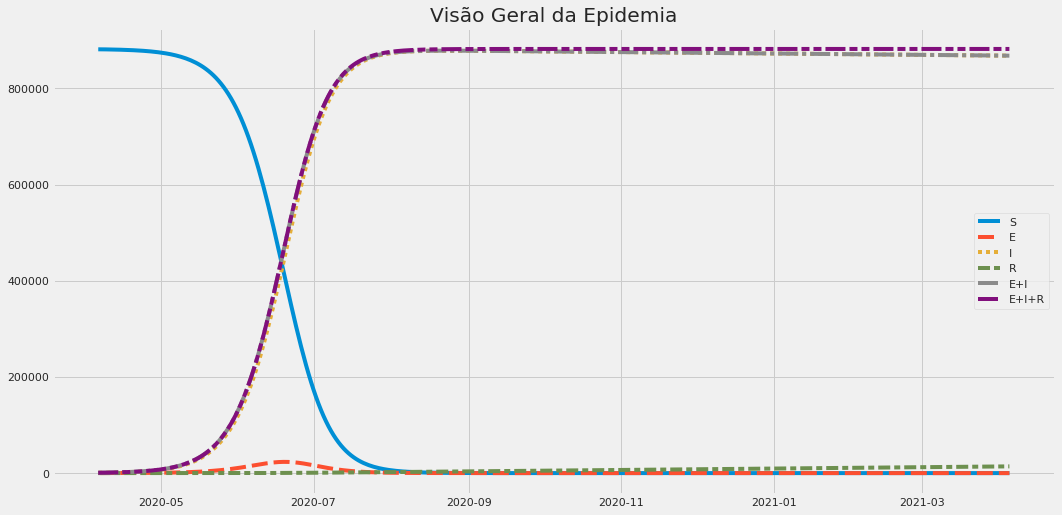

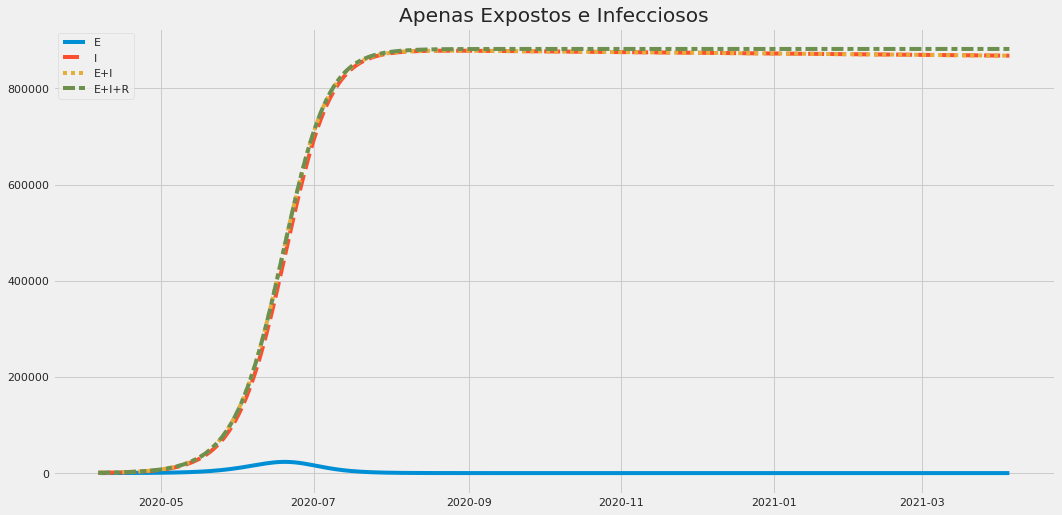

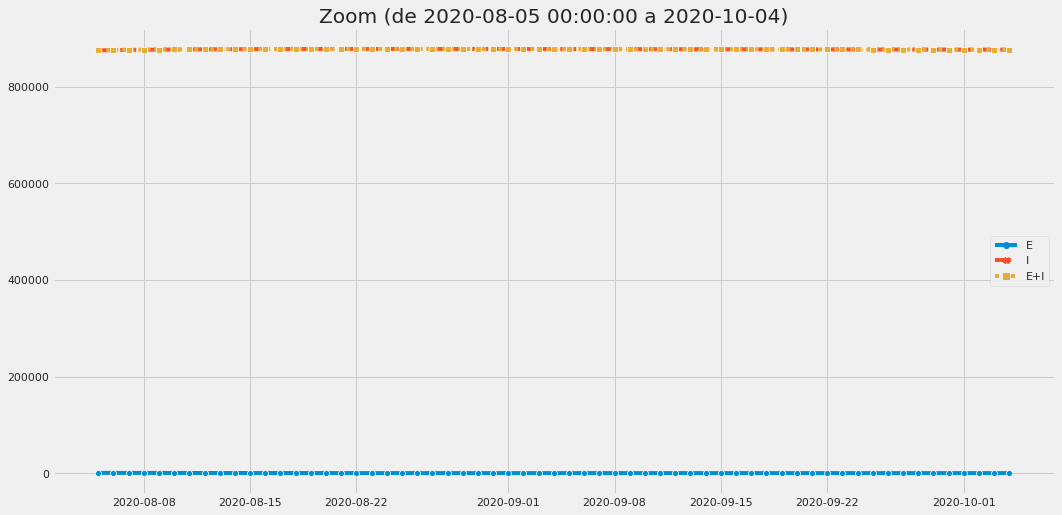

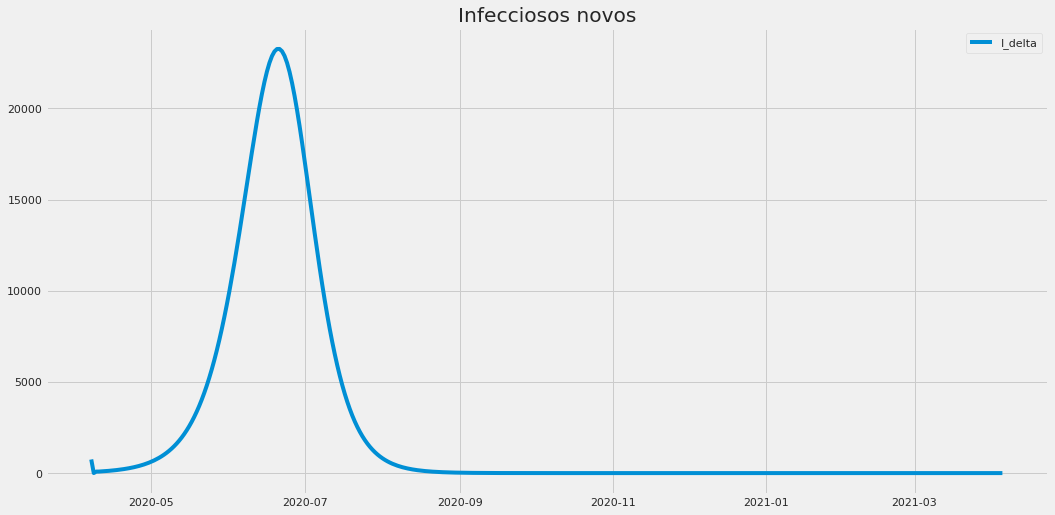

<Figure size 1152x576 with 0 Axes>

In [49]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [50]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,50,1,404,19,881935.0,NaN,6060,NaN
2020-05-01,83,0,487,19,881935.0,NaN,7305,NaN
2020-05-02,66,3,553,22,881935.0,NaN,8295,NaN
2020-05-03,105,3,658,25,881935.0,NaN,9870,NaN
2020-05-04,0,0,658,25,881935.0,NaN,9870,NaN


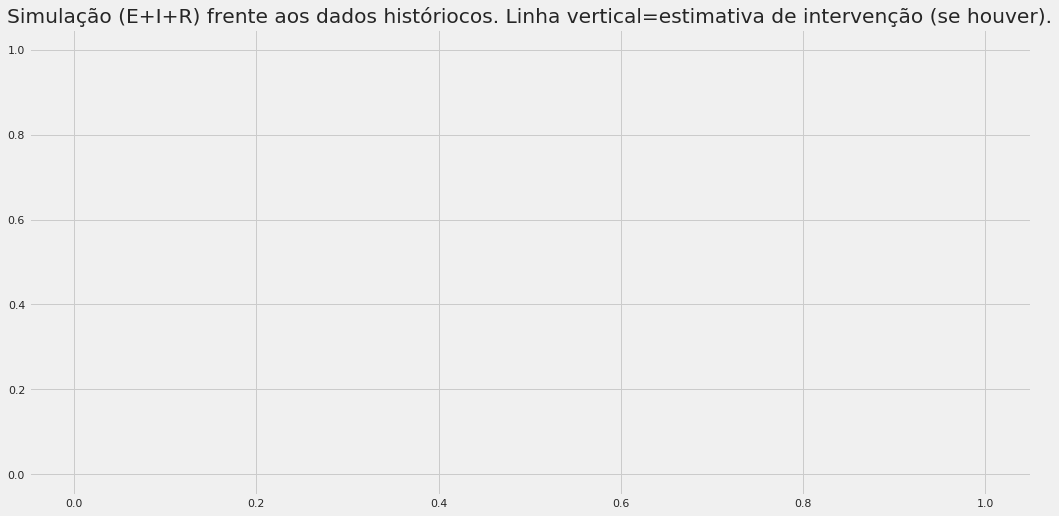

In [51]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [52]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [53]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 10/3000 [00:00<00:31, 94.70trial/s, best loss: 1755.2664474931555]

  1%|          | 19/3000 [00:00<00:32, 91.79trial/s, best loss: 399.56808686034304]

  1%|          | 24/3000 [00:00<00:44, 67.40trial/s, best loss: 399.56808686034304]

  1%|          | 29/3000 [00:00<00:49, 59.95trial/s, best loss: 399.56808686034304]

  1%|          | 34/3000 [00:00<00:53, 55.48trial/s, best loss: 399.56808686034304]

  1%|▏         | 39/3000 [00:00<00:55, 53.01trial/s, best loss: 399.56808686034304]

  1%|▏         | 44/3000 [00:00<00:57, 51.13trial/s, best loss: 399.56808686034304]

  2%|▏         | 49/3000 [00:00<00:58, 50.40trial/s, best loss: 399.56808686034304]

  2%|▏         | 54/3000 [00:00<01:04, 45.81trial/s, best loss: 399.56808686034304]

  2%|▏         | 59/3000 [00:01<01:11, 41.03trial/s, best loss: 399.56808686034304]

  2%|▏         | 64/3000 [00:01<01:09, 42.21trial/s, best loss: 399.56808686034304]

  2%|▏         | 69/3000 [00:01<01:11, 41.03trial/s, best loss: 389.6263794410357] 

  2%|▏         | 74/3000 [00:01<01:11, 41.03trial/s, best loss: 365.31125317660366]

  3%|▎         | 79/3000 [00:01<01:12, 40.47trial/s, best loss: 365.31125317660366]

  3%|▎         | 84/3000 [00:01<01:13, 39.87trial/s, best loss: 365.31125317660366]

  3%|▎         | 88/3000 [00:01<01:22, 35.34trial/s, best loss: 365.31125317660366]

  3%|▎         | 93/3000 [00:02<01:17, 37.32trial/s, best loss: 365.31125317660366]

  3%|▎         | 97/3000 [00:02<01:19, 36.72trial/s, best loss: 365.31125317660366]

  3%|▎         | 102/3000 [00:02<01:17, 37.42trial/s, best loss: 365.31125317660366]

  4%|▎         | 106/3000 [00:02<01:18, 37.05trial/s, best loss: 365.31125317660366]

  4%|▎         | 111/3000 [00:02<01:15, 38.50trial/s, best loss: 365.31125317660366]

  4%|▍         | 115/3000 [00:02<01:18, 36.90trial/s, best loss: 365.31125317660366]

  4%|▍         | 119/3000 [00:02<01:21, 35.42trial/s, best loss: 365.31125317660366]

  4%|▍         | 123/3000 [00:02<01:22, 34.81trial/s, best loss: 325.2225155154952] 

  4%|▍         | 127/3000 [00:02<01:20, 35.69trial/s, best loss: 325.2225155154952]

  4%|▍         | 131/3000 [00:03<01:17, 36.80trial/s, best loss: 325.2225155154952]

  4%|▍         | 135/3000 [00:03<01:16, 37.61trial/s, best loss: 325.2225155154952]

  5%|▍         | 139/3000 [00:03<01:19, 35.89trial/s, best loss: 325.2225155154952]

  5%|▍         | 143/3000 [00:03<01:20, 35.65trial/s, best loss: 325.2225155154952]

  5%|▍         | 147/3000 [00:03<01:20, 35.55trial/s, best loss: 325.2225155154952]

  5%|▌         | 151/3000 [00:03<01:27, 32.74trial/s, best loss: 325.2225155154952]

  5%|▌         | 155/3000 [00:03<01:23, 33.98trial/s, best loss: 325.2225155154952]

  5%|▌         | 159/3000 [00:03<01:20, 35.09trial/s, best loss: 325.2225155154952]

  5%|▌         | 163/3000 [00:03<01:22, 34.51trial/s, best loss: 325.2225155154952]

  6%|▌         | 168/3000 [00:04<01:18, 36.29trial/s, best loss: 325.2225155154952]

  6%|▌         | 173/3000 [00:04<01:15, 37.52trial/s, best loss: 325.2225155154952]

  6%|▌         | 177/3000 [00:04<01:17, 36.50trial/s, best loss: 325.2225155154952]

  6%|▌         | 182/3000 [00:04<01:14, 37.83trial/s, best loss: 325.2225155154952]

  6%|▌         | 186/3000 [00:04<01:13, 38.09trial/s, best loss: 325.2225155154952]

  6%|▋         | 190/3000 [00:04<01:23, 33.77trial/s, best loss: 325.2225155154952]

  6%|▋         | 194/3000 [00:04<01:22, 34.04trial/s, best loss: 325.2225155154952]

  7%|▋         | 198/3000 [00:04<01:22, 33.88trial/s, best loss: 325.2225155154952]

  7%|▋         | 202/3000 [00:05<01:19, 35.17trial/s, best loss: 325.2225155154952]

  7%|▋         | 207/3000 [00:05<01:15, 36.85trial/s, best loss: 325.2225155154952]

  7%|▋         | 211/3000 [00:05<01:16, 36.49trial/s, best loss: 325.2225155154952]

  7%|▋         | 215/3000 [00:05<01:19, 34.94trial/s, best loss: 325.2225155154952]

  7%|▋         | 219/3000 [00:05<01:17, 36.05trial/s, best loss: 325.2225155154952]

  7%|▋         | 223/3000 [00:05<01:20, 34.36trial/s, best loss: 325.2225155154952]

  8%|▊         | 227/3000 [00:05<01:18, 35.35trial/s, best loss: 325.2225155154952]

  8%|▊         | 231/3000 [00:05<01:21, 33.84trial/s, best loss: 325.2225155154952]

  8%|▊         | 235/3000 [00:06<01:23, 33.11trial/s, best loss: 325.2225155154952]

  8%|▊         | 239/3000 [00:06<01:22, 33.31trial/s, best loss: 325.2225155154952]

  8%|▊         | 243/3000 [00:06<01:22, 33.55trial/s, best loss: 325.2225155154952]

  8%|▊         | 247/3000 [00:06<01:21, 33.74trial/s, best loss: 325.2225155154952]

  8%|▊         | 251/3000 [00:06<01:18, 34.87trial/s, best loss: 325.2225155154952]

  8%|▊         | 255/3000 [00:06<01:26, 31.72trial/s, best loss: 325.2225155154952]

  9%|▊         | 259/3000 [00:06<01:21, 33.79trial/s, best loss: 325.2225155154952]

  9%|▉         | 263/3000 [00:06<01:17, 35.31trial/s, best loss: 325.2225155154952]

  9%|▉         | 267/3000 [00:06<01:14, 36.50trial/s, best loss: 325.2225155154952]

  9%|▉         | 271/3000 [00:07<01:15, 36.31trial/s, best loss: 325.2225155154952]

  9%|▉         | 275/3000 [00:07<01:15, 36.10trial/s, best loss: 325.2225155154952]

  9%|▉         | 279/3000 [00:07<01:15, 35.96trial/s, best loss: 325.2225155154952]

  9%|▉         | 283/3000 [00:07<01:16, 35.51trial/s, best loss: 325.2225155154952]

 10%|▉         | 287/3000 [00:07<01:14, 36.17trial/s, best loss: 325.2225155154952]

 10%|▉         | 291/3000 [00:07<01:15, 36.04trial/s, best loss: 325.2225155154952]

 10%|▉         | 295/3000 [00:07<01:15, 35.87trial/s, best loss: 325.2225155154952]

 10%|▉         | 299/3000 [00:07<01:15, 35.92trial/s, best loss: 315.26198338710424]

 10%|█         | 303/3000 [00:07<01:14, 36.09trial/s, best loss: 315.26198338710424]

 10%|█         | 307/3000 [00:08<01:14, 36.38trial/s, best loss: 315.26198338710424]

 10%|█         | 311/3000 [00:08<01:13, 36.40trial/s, best loss: 315.26198338710424]

 10%|█         | 315/3000 [00:08<01:13, 36.38trial/s, best loss: 315.26198338710424]

 11%|█         | 319/3000 [00:08<01:16, 35.17trial/s, best loss: 315.26198338710424]

 11%|█         | 323/3000 [00:08<01:22, 32.31trial/s, best loss: 315.26198338710424]

 11%|█         | 327/3000 [00:08<01:20, 33.38trial/s, best loss: 315.26198338710424]

 11%|█         | 331/3000 [00:08<01:18, 34.09trial/s, best loss: 315.26198338710424]

 11%|█         | 335/3000 [00:08<01:18, 34.08trial/s, best loss: 315.26198338710424]

 11%|█▏        | 339/3000 [00:08<01:17, 34.13trial/s, best loss: 315.26198338710424]

 11%|█▏        | 343/3000 [00:09<01:17, 34.08trial/s, best loss: 315.26198338710424]

 12%|█▏        | 347/3000 [00:09<01:18, 33.80trial/s, best loss: 315.26198338710424]

 12%|█▏        | 351/3000 [00:09<01:20, 32.77trial/s, best loss: 315.26198338710424]

 12%|█▏        | 355/3000 [00:09<01:20, 32.91trial/s, best loss: 315.26198338710424]

 12%|█▏        | 359/3000 [00:09<01:23, 31.65trial/s, best loss: 315.26198338710424]

 12%|█▏        | 363/3000 [00:09<01:23, 31.42trial/s, best loss: 315.26198338710424]

 12%|█▏        | 367/3000 [00:09<01:23, 31.55trial/s, best loss: 315.26198338710424]

 12%|█▏        | 371/3000 [00:09<01:23, 31.50trial/s, best loss: 315.26198338710424]

 12%|█▎        | 375/3000 [00:10<01:22, 31.77trial/s, best loss: 315.26198338710424]

 13%|█▎        | 379/3000 [00:10<01:23, 31.53trial/s, best loss: 315.26198338710424]

 13%|█▎        | 383/3000 [00:10<01:26, 30.19trial/s, best loss: 315.26198338710424]

 13%|█▎        | 387/3000 [00:10<01:25, 30.41trial/s, best loss: 315.26198338710424]

 13%|█▎        | 391/3000 [00:10<01:35, 27.28trial/s, best loss: 315.26198338710424]

 13%|█▎        | 394/3000 [00:10<01:35, 27.20trial/s, best loss: 315.26198338710424]

 13%|█▎        | 398/3000 [00:10<01:31, 28.41trial/s, best loss: 315.26198338710424]

 13%|█▎        | 402/3000 [00:11<01:29, 28.97trial/s, best loss: 315.26198338710424]

 14%|█▎        | 406/3000 [00:11<01:27, 29.53trial/s, best loss: 237.29503392898144]

 14%|█▎        | 409/3000 [00:11<01:35, 27.25trial/s, best loss: 237.29503392898144]

 14%|█▍        | 413/3000 [00:11<01:31, 28.27trial/s, best loss: 237.29503392898144]

 14%|█▍        | 417/3000 [00:11<01:29, 28.93trial/s, best loss: 237.29503392898144]

 14%|█▍        | 420/3000 [00:11<01:28, 29.05trial/s, best loss: 237.29503392898144]

 14%|█▍        | 423/3000 [00:11<01:41, 25.48trial/s, best loss: 237.29503392898144]

 14%|█▍        | 426/3000 [00:11<01:42, 25.06trial/s, best loss: 237.29503392898144]

 14%|█▍        | 429/3000 [00:12<01:37, 26.33trial/s, best loss: 237.29503392898144]

 14%|█▍        | 433/3000 [00:12<01:33, 27.48trial/s, best loss: 237.29503392898144]

 15%|█▍        | 436/3000 [00:12<01:33, 27.37trial/s, best loss: 237.29503392898144]

 15%|█▍        | 440/3000 [00:12<01:30, 28.38trial/s, best loss: 237.29503392898144]

 15%|█▍        | 444/3000 [00:12<01:28, 28.86trial/s, best loss: 237.29503392898144]

 15%|█▍        | 447/3000 [00:12<01:28, 28.88trial/s, best loss: 237.29503392898144]

 15%|█▌        | 450/3000 [00:12<01:28, 28.88trial/s, best loss: 237.29503392898144]

 15%|█▌        | 453/3000 [00:12<01:28, 28.86trial/s, best loss: 237.29503392898144]

 15%|█▌        | 456/3000 [00:12<01:28, 28.77trial/s, best loss: 237.29503392898144]

 15%|█▌        | 460/3000 [00:13<01:26, 29.27trial/s, best loss: 237.29503392898144]

 15%|█▌        | 463/3000 [00:13<01:26, 29.29trial/s, best loss: 237.29503392898144]

 16%|█▌        | 466/3000 [00:13<01:29, 28.26trial/s, best loss: 237.29503392898144]

 16%|█▌        | 470/3000 [00:13<01:28, 28.75trial/s, best loss: 237.29503392898144]

 16%|█▌        | 473/3000 [00:13<01:27, 28.87trial/s, best loss: 237.29503392898144]

 16%|█▌        | 476/3000 [00:13<01:27, 28.82trial/s, best loss: 237.29503392898144]

 16%|█▌        | 479/3000 [00:13<01:26, 29.03trial/s, best loss: 237.29503392898144]

 16%|█▌        | 482/3000 [00:13<01:30, 27.76trial/s, best loss: 237.29503392898144]

 16%|█▌        | 485/3000 [00:14<01:30, 27.80trial/s, best loss: 237.29503392898144]

 16%|█▋        | 488/3000 [00:14<01:28, 28.23trial/s, best loss: 237.29503392898144]

 16%|█▋        | 491/3000 [00:14<01:28, 28.45trial/s, best loss: 237.29503392898144]

 16%|█▋        | 494/3000 [00:14<01:29, 28.14trial/s, best loss: 237.29503392898144]

 17%|█▋        | 497/3000 [00:14<01:27, 28.62trial/s, best loss: 237.29503392898144]

 17%|█▋        | 500/3000 [00:14<01:26, 28.83trial/s, best loss: 237.29503392898144]

 17%|█▋        | 503/3000 [00:14<01:26, 28.76trial/s, best loss: 237.29503392898144]

 17%|█▋        | 506/3000 [00:14<01:26, 28.86trial/s, best loss: 237.29503392898144]

 17%|█▋        | 509/3000 [00:14<01:26, 28.91trial/s, best loss: 237.29503392898144]

 17%|█▋        | 512/3000 [00:14<01:28, 28.23trial/s, best loss: 237.29503392898144]

 17%|█▋        | 515/3000 [00:15<01:29, 27.72trial/s, best loss: 237.29503392898144]

 17%|█▋        | 518/3000 [00:15<01:29, 27.72trial/s, best loss: 237.29503392898144]

 17%|█▋        | 521/3000 [00:15<01:32, 26.82trial/s, best loss: 237.29503392898144]

 17%|█▋        | 524/3000 [00:15<01:38, 25.26trial/s, best loss: 237.29503392898144]

 18%|█▊        | 527/3000 [00:15<01:43, 23.97trial/s, best loss: 237.29503392898144]

 18%|█▊        | 530/3000 [00:15<01:41, 24.25trial/s, best loss: 237.29503392898144]

 18%|█▊        | 533/3000 [00:15<01:37, 25.40trial/s, best loss: 237.29503392898144]

 18%|█▊        | 536/3000 [00:15<01:34, 26.04trial/s, best loss: 237.29503392898144]

 18%|█▊        | 539/3000 [00:16<01:32, 26.69trial/s, best loss: 237.29503392898144]

 18%|█▊        | 542/3000 [00:16<01:30, 27.15trial/s, best loss: 237.29503392898144]

 18%|█▊        | 545/3000 [00:16<01:30, 27.24trial/s, best loss: 237.29503392898144]

 18%|█▊        | 548/3000 [00:16<01:33, 26.36trial/s, best loss: 237.29503392898144]

 18%|█▊        | 551/3000 [00:16<01:32, 26.57trial/s, best loss: 237.29503392898144]

 18%|█▊        | 554/3000 [00:16<01:32, 26.54trial/s, best loss: 237.29503392898144]

 19%|█▊        | 557/3000 [00:16<01:31, 26.79trial/s, best loss: 237.29503392898144]

 19%|█▊        | 560/3000 [00:16<01:30, 27.09trial/s, best loss: 237.29503392898144]

 19%|█▉        | 563/3000 [00:16<01:29, 27.26trial/s, best loss: 237.29503392898144]

 19%|█▉        | 566/3000 [00:16<01:28, 27.42trial/s, best loss: 237.29503392898144]

 19%|█▉        | 569/3000 [00:17<01:28, 27.58trial/s, best loss: 237.29503392898144]

 19%|█▉        | 572/3000 [00:17<01:28, 27.39trial/s, best loss: 237.29503392898144]

 19%|█▉        | 575/3000 [00:17<01:30, 26.70trial/s, best loss: 237.29503392898144]

 19%|█▉        | 578/3000 [00:17<01:29, 26.97trial/s, best loss: 237.29503392898144]

 19%|█▉        | 581/3000 [00:17<01:40, 24.15trial/s, best loss: 237.29503392898144]

 19%|█▉        | 584/3000 [00:17<01:38, 24.45trial/s, best loss: 237.29503392898144]

 20%|█▉        | 587/3000 [00:17<01:37, 24.76trial/s, best loss: 237.29503392898144]

 20%|█▉        | 590/3000 [00:17<01:36, 25.03trial/s, best loss: 237.29503392898144]

 20%|█▉        | 593/3000 [00:18<01:35, 25.11trial/s, best loss: 237.29503392898144]

 20%|█▉        | 596/3000 [00:18<01:35, 25.23trial/s, best loss: 237.29503392898144]

 20%|█▉        | 599/3000 [00:18<01:52, 21.26trial/s, best loss: 237.29503392898144]

 20%|██        | 602/3000 [00:18<01:50, 21.74trial/s, best loss: 237.29503392898144]

 20%|██        | 605/3000 [00:18<01:45, 22.74trial/s, best loss: 237.29503392898144]

 20%|██        | 608/3000 [00:18<01:43, 23.02trial/s, best loss: 237.29503392898144]

 20%|██        | 611/3000 [00:18<01:43, 23.17trial/s, best loss: 228.53507967377217]

 20%|██        | 614/3000 [00:19<01:42, 23.20trial/s, best loss: 228.53507967377217]

 21%|██        | 617/3000 [00:19<01:40, 23.64trial/s, best loss: 228.53507967377217]

 21%|██        | 620/3000 [00:19<01:38, 24.12trial/s, best loss: 228.53507967377217]

 21%|██        | 623/3000 [00:19<01:41, 23.43trial/s, best loss: 228.53507967377217]

 21%|██        | 626/3000 [00:19<01:41, 23.29trial/s, best loss: 228.53507967377217]

 21%|██        | 629/3000 [00:19<01:42, 23.19trial/s, best loss: 228.53507967377217]

 21%|██        | 632/3000 [00:19<01:37, 24.20trial/s, best loss: 228.53507967377217]

 21%|██        | 635/3000 [00:19<01:35, 24.85trial/s, best loss: 228.53507967377217]

 21%|██▏       | 638/3000 [00:19<01:34, 25.12trial/s, best loss: 228.53507967377217]

 21%|██▏       | 641/3000 [00:20<01:37, 24.32trial/s, best loss: 228.53507967377217]

 21%|██▏       | 644/3000 [00:20<01:35, 24.74trial/s, best loss: 228.53507967377217]

 22%|██▏       | 647/3000 [00:20<01:35, 24.54trial/s, best loss: 228.53507967377217]

 22%|██▏       | 650/3000 [00:20<01:34, 24.76trial/s, best loss: 228.53507967377217]

 22%|██▏       | 653/3000 [00:20<01:34, 24.86trial/s, best loss: 228.53507967377217]

 22%|██▏       | 656/3000 [00:20<01:32, 25.24trial/s, best loss: 228.53507967377217]

 22%|██▏       | 659/3000 [00:20<01:34, 24.76trial/s, best loss: 228.53507967377217]

 22%|██▏       | 662/3000 [00:20<01:33, 25.03trial/s, best loss: 228.53507967377217]

 22%|██▏       | 665/3000 [00:21<01:32, 25.30trial/s, best loss: 228.53507967377217]

 22%|██▏       | 668/3000 [00:21<01:31, 25.54trial/s, best loss: 228.53507967377217]

 22%|██▏       | 671/3000 [00:21<01:44, 22.30trial/s, best loss: 228.53507967377217]

 22%|██▏       | 674/3000 [00:21<01:39, 23.32trial/s, best loss: 228.53507967377217]

 23%|██▎       | 677/3000 [00:21<01:37, 23.85trial/s, best loss: 228.53507967377217]

 23%|██▎       | 680/3000 [00:21<01:35, 24.21trial/s, best loss: 228.53507967377217]

 23%|██▎       | 683/3000 [00:21<01:34, 24.55trial/s, best loss: 228.53507967377217]

 23%|██▎       | 686/3000 [00:21<01:33, 24.88trial/s, best loss: 228.53507967377217]

 23%|██▎       | 689/3000 [00:22<01:31, 25.32trial/s, best loss: 228.53507967377217]

 23%|██▎       | 692/3000 [00:22<01:31, 25.23trial/s, best loss: 228.53507967377217]

 23%|██▎       | 695/3000 [00:22<01:34, 24.45trial/s, best loss: 228.53507967377217]

 23%|██▎       | 698/3000 [00:22<01:32, 24.81trial/s, best loss: 228.53507967377217]

 23%|██▎       | 701/3000 [00:22<01:31, 25.10trial/s, best loss: 228.53507967377217]

 23%|██▎       | 704/3000 [00:22<01:31, 25.02trial/s, best loss: 228.53507967377217]

 24%|██▎       | 707/3000 [00:22<01:31, 25.02trial/s, best loss: 228.53507967377217]

 24%|██▎       | 710/3000 [00:22<01:31, 25.09trial/s, best loss: 228.53507967377217]

 24%|██▍       | 713/3000 [00:23<01:33, 24.59trial/s, best loss: 228.53507967377217]

 24%|██▍       | 716/3000 [00:23<01:32, 24.76trial/s, best loss: 228.53507967377217]

 24%|██▍       | 719/3000 [00:23<01:32, 24.54trial/s, best loss: 228.53507967377217]

 24%|██▍       | 722/3000 [00:23<01:33, 24.48trial/s, best loss: 228.53507967377217]

 24%|██▍       | 725/3000 [00:23<01:42, 22.23trial/s, best loss: 228.53507967377217]

 24%|██▍       | 728/3000 [00:23<01:40, 22.70trial/s, best loss: 228.53507967377217]

 24%|██▍       | 731/3000 [00:23<01:37, 23.33trial/s, best loss: 228.53507967377217]

 24%|██▍       | 734/3000 [00:23<01:35, 23.64trial/s, best loss: 228.53507967377217]

 25%|██▍       | 737/3000 [00:24<01:33, 24.09trial/s, best loss: 228.53507967377217]

 25%|██▍       | 740/3000 [00:24<01:33, 24.09trial/s, best loss: 228.53507967377217]

 25%|██▍       | 743/3000 [00:24<01:37, 23.08trial/s, best loss: 228.53507967377217]

 25%|██▍       | 746/3000 [00:24<01:36, 23.43trial/s, best loss: 228.53507967377217]

 25%|██▍       | 749/3000 [00:24<01:36, 23.23trial/s, best loss: 228.53507967377217]

 25%|██▌       | 752/3000 [00:24<01:36, 23.21trial/s, best loss: 228.53507967377217]

 25%|██▌       | 755/3000 [00:24<01:35, 23.39trial/s, best loss: 228.53507967377217]

 25%|██▌       | 758/3000 [00:25<01:48, 20.74trial/s, best loss: 228.53507967377217]

 25%|██▌       | 761/3000 [00:25<01:44, 21.50trial/s, best loss: 228.53507967377217]

 25%|██▌       | 764/3000 [00:25<01:52, 19.89trial/s, best loss: 228.53507967377217]

 26%|██▌       | 767/3000 [00:25<01:46, 21.06trial/s, best loss: 228.53507967377217]

 26%|██▌       | 770/3000 [00:25<01:43, 21.52trial/s, best loss: 228.53507967377217]

 26%|██▌       | 773/3000 [00:25<01:40, 22.15trial/s, best loss: 228.53507967377217]

 26%|██▌       | 776/3000 [00:25<01:38, 22.69trial/s, best loss: 228.53507967377217]

 26%|██▌       | 779/3000 [00:25<01:36, 23.10trial/s, best loss: 228.53507967377217]

 26%|██▌       | 782/3000 [00:26<01:34, 23.45trial/s, best loss: 228.53507967377217]

 26%|██▌       | 785/3000 [00:26<01:34, 23.43trial/s, best loss: 228.53507967377217]

 26%|██▋       | 788/3000 [00:26<01:38, 22.47trial/s, best loss: 228.53507967377217]

 26%|██▋       | 791/3000 [00:26<01:36, 22.86trial/s, best loss: 228.53507967377217]

 26%|██▋       | 794/3000 [00:26<01:36, 22.75trial/s, best loss: 228.53507967377217]

 27%|██▋       | 797/3000 [00:26<01:35, 23.18trial/s, best loss: 228.53507967377217]

 27%|██▋       | 800/3000 [00:26<01:43, 21.17trial/s, best loss: 228.53507967377217]

 27%|██▋       | 803/3000 [00:27<01:39, 22.01trial/s, best loss: 228.53507967377217]

 27%|██▋       | 806/3000 [00:27<01:38, 22.36trial/s, best loss: 228.53507967377217]

 27%|██▋       | 809/3000 [00:27<01:39, 22.08trial/s, best loss: 228.53507967377217]

 27%|██▋       | 812/3000 [00:27<01:39, 22.01trial/s, best loss: 228.53507967377217]

 27%|██▋       | 815/3000 [00:27<01:40, 21.76trial/s, best loss: 228.53507967377217]

 27%|██▋       | 818/3000 [00:27<01:39, 21.90trial/s, best loss: 228.53507967377217]

 27%|██▋       | 821/3000 [00:27<01:39, 21.89trial/s, best loss: 228.53507967377217]

 27%|██▋       | 824/3000 [00:27<01:38, 22.07trial/s, best loss: 228.53507967377217]

 28%|██▊       | 827/3000 [00:28<01:39, 21.77trial/s, best loss: 228.53507967377217]

 28%|██▊       | 830/3000 [00:28<01:41, 21.37trial/s, best loss: 228.53507967377217]

 28%|██▊       | 833/3000 [00:28<01:43, 20.84trial/s, best loss: 228.53507967377217]

 28%|██▊       | 836/3000 [00:28<01:52, 19.24trial/s, best loss: 228.53507967377217]

 28%|██▊       | 838/3000 [00:28<01:51, 19.35trial/s, best loss: 228.53507967377217]

 28%|██▊       | 841/3000 [00:28<01:48, 19.96trial/s, best loss: 228.53507967377217]

 28%|██▊       | 844/3000 [00:28<01:44, 20.64trial/s, best loss: 228.53507967377217]

 28%|██▊       | 847/3000 [00:29<01:42, 20.94trial/s, best loss: 228.53507967377217]

 28%|██▊       | 850/3000 [00:29<01:41, 21.22trial/s, best loss: 228.53507967377217]

 28%|██▊       | 853/3000 [00:29<01:46, 20.10trial/s, best loss: 228.53507967377217]

 29%|██▊       | 856/3000 [00:29<01:46, 20.16trial/s, best loss: 228.53507967377217]

 29%|██▊       | 859/3000 [00:29<01:44, 20.43trial/s, best loss: 228.53507967377217]

 29%|██▊       | 862/3000 [00:29<01:42, 20.85trial/s, best loss: 228.53507967377217]

 29%|██▉       | 865/3000 [00:29<01:41, 20.94trial/s, best loss: 228.53507967377217]

 29%|██▉       | 868/3000 [00:30<01:43, 20.65trial/s, best loss: 228.53507967377217]

 29%|██▉       | 871/3000 [00:30<01:55, 18.49trial/s, best loss: 228.53507967377217]

 29%|██▉       | 874/3000 [00:30<01:51, 19.12trial/s, best loss: 228.53507967377217]

 29%|██▉       | 876/3000 [00:30<01:50, 19.19trial/s, best loss: 228.53507967377217]

 29%|██▉       | 879/3000 [00:30<01:47, 19.82trial/s, best loss: 228.53507967377217]

 29%|██▉       | 882/3000 [00:30<01:44, 20.28trial/s, best loss: 228.53507967377217]

 30%|██▉       | 885/3000 [00:31<01:42, 20.69trial/s, best loss: 228.53507967377217]

 30%|██▉       | 888/3000 [00:31<01:41, 20.73trial/s, best loss: 228.53507967377217]

 30%|██▉       | 891/3000 [00:31<01:56, 18.14trial/s, best loss: 228.53507967377217]

 30%|██▉       | 894/3000 [00:31<01:51, 18.95trial/s, best loss: 228.53507967377217]

 30%|██▉       | 897/3000 [00:31<01:47, 19.48trial/s, best loss: 228.53507967377217]

 30%|███       | 900/3000 [00:31<01:47, 19.55trial/s, best loss: 228.53507967377217]

 30%|███       | 902/3000 [00:31<01:47, 19.52trial/s, best loss: 228.53507967377217]

 30%|███       | 905/3000 [00:32<01:44, 20.06trial/s, best loss: 228.53507967377217]

 30%|███       | 908/3000 [00:32<01:53, 18.40trial/s, best loss: 228.53507967377217]

 30%|███       | 910/3000 [00:32<01:55, 18.09trial/s, best loss: 228.53507967377217]

 30%|███       | 913/3000 [00:32<01:51, 18.78trial/s, best loss: 228.53507967377217]

 30%|███       | 915/3000 [00:32<01:50, 18.94trial/s, best loss: 228.53507967377217]

 31%|███       | 918/3000 [00:32<01:47, 19.44trial/s, best loss: 228.53507967377217]

 31%|███       | 921/3000 [00:32<01:43, 20.07trial/s, best loss: 228.53507967377217]

 31%|███       | 924/3000 [00:33<01:42, 20.33trial/s, best loss: 228.53507967377217]

 31%|███       | 927/3000 [00:33<01:41, 20.47trial/s, best loss: 228.53507967377217]

 31%|███       | 930/3000 [00:33<01:43, 20.07trial/s, best loss: 228.53507967377217]

 31%|███       | 933/3000 [00:33<01:42, 20.23trial/s, best loss: 228.53507967377217]

 31%|███       | 936/3000 [00:33<01:43, 19.92trial/s, best loss: 228.53507967377217]

 31%|███▏      | 938/3000 [00:33<01:50, 18.67trial/s, best loss: 228.53507967377217]

 31%|███▏      | 940/3000 [00:33<01:56, 17.62trial/s, best loss: 228.53507967377217]

 31%|███▏      | 942/3000 [00:34<02:06, 16.28trial/s, best loss: 228.53507967377217]

 32%|███▏      | 945/3000 [00:34<01:57, 17.43trial/s, best loss: 228.53507967377217]

 32%|███▏      | 947/3000 [00:34<02:00, 17.05trial/s, best loss: 228.53507967377217]

 32%|███▏      | 950/3000 [00:34<01:54, 17.91trial/s, best loss: 228.53507967377217]

 32%|███▏      | 953/3000 [00:34<01:50, 18.49trial/s, best loss: 228.53507967377217]

 32%|███▏      | 955/3000 [00:34<01:48, 18.90trial/s, best loss: 228.53507967377217]

 32%|███▏      | 958/3000 [00:34<01:46, 19.13trial/s, best loss: 228.53507967377217]

 32%|███▏      | 960/3000 [00:34<01:47, 18.95trial/s, best loss: 228.53507967377217]

 32%|███▏      | 962/3000 [00:35<01:46, 19.13trial/s, best loss: 228.53507967377217]

 32%|███▏      | 965/3000 [00:35<01:45, 19.34trial/s, best loss: 228.53507967377217]

 32%|███▏      | 967/3000 [00:35<01:46, 19.10trial/s, best loss: 228.53507967377217]

 32%|███▏      | 970/3000 [00:35<01:43, 19.55trial/s, best loss: 228.53507967377217]

 32%|███▏      | 973/3000 [00:35<01:43, 19.59trial/s, best loss: 228.53507967377217]

 32%|███▎      | 975/3000 [00:35<01:43, 19.64trial/s, best loss: 228.53507967377217]

 33%|███▎      | 977/3000 [00:35<01:45, 19.10trial/s, best loss: 228.53507967377217]

 33%|███▎      | 979/3000 [00:35<01:58, 17.12trial/s, best loss: 228.53507967377217]

 33%|███▎      | 982/3000 [00:36<01:51, 18.09trial/s, best loss: 228.53507967377217]

 33%|███▎      | 985/3000 [00:36<01:46, 18.85trial/s, best loss: 228.53507967377217]

 33%|███▎      | 987/3000 [00:36<01:47, 18.79trial/s, best loss: 228.53507967377217]

 33%|███▎      | 990/3000 [00:36<01:44, 19.22trial/s, best loss: 228.53507967377217]

 33%|███▎      | 993/3000 [00:36<01:42, 19.60trial/s, best loss: 228.53507967377217]

 33%|███▎      | 996/3000 [00:36<01:40, 19.94trial/s, best loss: 228.53507967377217]

 33%|███▎      | 999/3000 [00:36<01:40, 19.98trial/s, best loss: 228.53507967377217]

 33%|███▎      | 1002/3000 [00:37<01:41, 19.65trial/s, best loss: 228.53507967377217]

 33%|███▎      | 1004/3000 [00:37<01:42, 19.43trial/s, best loss: 228.53507967377217]

 34%|███▎      | 1006/3000 [00:37<01:48, 18.38trial/s, best loss: 228.53507967377217]

 34%|███▎      | 1008/3000 [00:37<01:46, 18.70trial/s, best loss: 228.53507967377217]

 34%|███▎      | 1010/3000 [00:37<01:45, 18.94trial/s, best loss: 228.53507967377217]

 34%|███▎      | 1012/3000 [00:37<01:46, 18.67trial/s, best loss: 228.53507967377217]

 34%|███▍      | 1014/3000 [00:37<02:01, 16.38trial/s, best loss: 228.53507967377217]

 34%|███▍      | 1016/3000 [00:37<01:57, 16.86trial/s, best loss: 228.53507967377217]

 34%|███▍      | 1018/3000 [00:38<01:54, 17.24trial/s, best loss: 228.53507967377217]

 34%|███▍      | 1020/3000 [00:38<01:51, 17.82trial/s, best loss: 228.53507967377217]

 34%|███▍      | 1023/3000 [00:38<01:51, 17.69trial/s, best loss: 228.53507967377217]

 34%|███▍      | 1025/3000 [00:38<01:49, 18.09trial/s, best loss: 228.53507967377217]

 34%|███▍      | 1027/3000 [00:38<01:48, 18.14trial/s, best loss: 228.53507967377217]

 34%|███▍      | 1029/3000 [00:38<01:47, 18.30trial/s, best loss: 228.53507967377217]

 34%|███▍      | 1031/3000 [00:38<01:52, 17.55trial/s, best loss: 228.53507967377217]

 34%|███▍      | 1033/3000 [00:38<02:00, 16.35trial/s, best loss: 228.53507967377217]

 34%|███▍      | 1035/3000 [00:39<02:01, 16.18trial/s, best loss: 228.53507967377217]

 35%|███▍      | 1037/3000 [00:39<02:00, 16.25trial/s, best loss: 228.53507967377217]

 35%|███▍      | 1039/3000 [00:39<02:02, 15.97trial/s, best loss: 228.53507967377217]

 35%|███▍      | 1041/3000 [00:39<02:07, 15.32trial/s, best loss: 228.53507967377217]

 35%|███▍      | 1043/3000 [00:39<02:05, 15.59trial/s, best loss: 228.53507967377217]

 35%|███▍      | 1045/3000 [00:39<02:03, 15.81trial/s, best loss: 228.53507967377217]

 35%|███▍      | 1047/3000 [00:39<01:59, 16.32trial/s, best loss: 228.53507967377217]

 35%|███▍      | 1049/3000 [00:39<01:58, 16.50trial/s, best loss: 228.53507967377217]

 35%|███▌      | 1051/3000 [00:40<02:16, 14.26trial/s, best loss: 228.53507967377217]

 35%|███▌      | 1053/3000 [00:40<02:13, 14.62trial/s, best loss: 228.53507967377217]

 35%|███▌      | 1055/3000 [00:40<02:17, 14.16trial/s, best loss: 228.53507967377217]

 35%|███▌      | 1057/3000 [00:40<02:17, 14.16trial/s, best loss: 228.53507967377217]

 35%|███▌      | 1059/3000 [00:40<02:13, 14.59trial/s, best loss: 228.53507967377217]

 35%|███▌      | 1061/3000 [00:40<02:12, 14.66trial/s, best loss: 228.53507967377217]

 35%|███▌      | 1063/3000 [00:40<02:07, 15.22trial/s, best loss: 228.53507967377217]

 36%|███▌      | 1065/3000 [00:40<02:01, 15.97trial/s, best loss: 228.53507967377217]

 36%|███▌      | 1067/3000 [00:41<01:57, 16.48trial/s, best loss: 228.53507967377217]

 36%|███▌      | 1069/3000 [00:41<01:53, 17.06trial/s, best loss: 228.53507967377217]

 36%|███▌      | 1071/3000 [00:41<02:03, 15.66trial/s, best loss: 228.53507967377217]

 36%|███▌      | 1073/3000 [00:41<02:04, 15.53trial/s, best loss: 228.53507967377217]

 36%|███▌      | 1075/3000 [00:41<02:05, 15.40trial/s, best loss: 228.53507967377217]

 36%|███▌      | 1077/3000 [00:41<02:10, 14.72trial/s, best loss: 228.53507967377217]

 36%|███▌      | 1079/3000 [00:41<02:05, 15.29trial/s, best loss: 228.53507967377217]

 36%|███▌      | 1081/3000 [00:42<01:59, 16.08trial/s, best loss: 228.53507967377217]

 36%|███▌      | 1083/3000 [00:42<01:52, 17.00trial/s, best loss: 228.53507967377217]

 36%|███▌      | 1085/3000 [00:42<01:48, 17.71trial/s, best loss: 213.80360144060353]

 36%|███▌      | 1087/3000 [00:42<02:23, 13.31trial/s, best loss: 213.80360144060353]

 36%|███▋      | 1089/3000 [00:42<02:16, 14.00trial/s, best loss: 213.80360144060353]

 36%|███▋      | 1091/3000 [00:42<02:10, 14.65trial/s, best loss: 213.80360144060353]

 36%|███▋      | 1093/3000 [00:42<02:02, 15.63trial/s, best loss: 213.80360144060353]

 36%|███▋      | 1095/3000 [00:42<01:59, 15.95trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1097/3000 [00:43<01:53, 16.80trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1099/3000 [00:43<01:50, 17.26trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1101/3000 [00:43<01:47, 17.60trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1103/3000 [00:43<01:49, 17.38trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1105/3000 [00:43<01:46, 17.77trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1107/3000 [00:43<01:45, 18.00trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1109/3000 [00:43<01:48, 17.38trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1111/3000 [00:43<01:47, 17.61trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1113/3000 [00:43<01:45, 17.80trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1115/3000 [00:44<01:45, 17.88trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1117/3000 [00:44<01:43, 18.18trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1119/3000 [00:44<01:42, 18.30trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1121/3000 [00:44<02:01, 15.47trial/s, best loss: 213.80360144060353]

 37%|███▋      | 1123/3000 [00:44<02:01, 15.48trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1125/3000 [00:44<02:01, 15.40trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1127/3000 [00:44<01:55, 16.18trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1129/3000 [00:44<01:50, 16.86trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1131/3000 [00:45<01:46, 17.50trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1133/3000 [00:45<01:45, 17.65trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1135/3000 [00:45<01:43, 18.01trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1137/3000 [00:45<01:50, 16.81trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1139/3000 [00:45<01:48, 17.09trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1141/3000 [00:45<01:45, 17.57trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1143/3000 [00:45<01:58, 15.68trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1145/3000 [00:45<01:52, 16.56trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1147/3000 [00:45<01:47, 17.21trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1149/3000 [00:46<01:45, 17.62trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1151/3000 [00:46<01:43, 17.93trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1153/3000 [00:46<01:44, 17.59trial/s, best loss: 213.80360144060353]

 38%|███▊      | 1155/3000 [00:46<01:44, 17.72trial/s, best loss: 213.80360144060353]

 39%|███▊      | 1157/3000 [00:46<01:42, 18.05trial/s, best loss: 213.80360144060353]

 39%|███▊      | 1159/3000 [00:46<01:40, 18.34trial/s, best loss: 213.80360144060353]

 39%|███▊      | 1161/3000 [00:46<01:39, 18.56trial/s, best loss: 213.80360144060353]

 39%|███▉      | 1163/3000 [00:46<01:38, 18.72trial/s, best loss: 213.80360144060353]

 39%|███▉      | 1165/3000 [00:46<01:38, 18.69trial/s, best loss: 213.80360144060353]

 39%|███▉      | 1167/3000 [00:47<01:37, 18.84trial/s, best loss: 213.80360144060353]

 39%|███▉      | 1169/3000 [00:47<01:36, 18.89trial/s, best loss: 213.80360144060353]

 39%|███▉      | 1171/3000 [00:47<01:38, 18.58trial/s, best loss: 213.80360144060353]

 39%|███▉      | 1173/3000 [00:47<01:41, 18.07trial/s, best loss: 213.80360144060353]

 39%|███▉      | 1175/3000 [00:47<01:39, 18.30trial/s, best loss: 213.80360144060353]

 39%|███▉      | 1177/3000 [00:47<01:40, 18.07trial/s, best loss: 213.80360144060353]

 39%|███▉      | 1179/3000 [00:47<01:45, 17.34trial/s, best loss: 213.80360144060353]

 39%|███▉      | 1181/3000 [00:47<01:42, 17.67trial/s, best loss: 213.80360144060353]

 39%|███▉      | 1183/3000 [00:47<01:40, 18.02trial/s, best loss: 213.80360144060353]

 40%|███▉      | 1185/3000 [00:48<01:39, 18.25trial/s, best loss: 213.80360144060353]

 40%|███▉      | 1187/3000 [00:48<01:38, 18.38trial/s, best loss: 213.80360144060353]

 40%|███▉      | 1189/3000 [00:48<01:38, 18.40trial/s, best loss: 213.80360144060353]

 40%|███▉      | 1191/3000 [00:48<01:40, 17.91trial/s, best loss: 213.80360144060353]

 40%|███▉      | 1193/3000 [00:48<01:39, 18.18trial/s, best loss: 213.80360144060353]

 40%|███▉      | 1195/3000 [00:48<01:38, 18.32trial/s, best loss: 213.80360144060353]

 40%|███▉      | 1197/3000 [00:48<01:40, 17.98trial/s, best loss: 213.80360144060353]

 40%|███▉      | 1199/3000 [00:48<01:39, 18.18trial/s, best loss: 213.80360144060353]

 40%|████      | 1201/3000 [00:48<01:38, 18.35trial/s, best loss: 213.80360144060353]

 40%|████      | 1203/3000 [00:49<01:36, 18.53trial/s, best loss: 213.80360144060353]

 40%|████      | 1205/3000 [00:49<01:36, 18.64trial/s, best loss: 213.80360144060353]

 40%|████      | 1207/3000 [00:49<01:37, 18.31trial/s, best loss: 213.80360144060353]

 40%|████      | 1209/3000 [00:49<01:41, 17.69trial/s, best loss: 213.80360144060353]

 40%|████      | 1211/3000 [00:49<01:39, 17.95trial/s, best loss: 213.80360144060353]

 40%|████      | 1213/3000 [00:49<01:38, 18.05trial/s, best loss: 213.80360144060353]

 40%|████      | 1215/3000 [00:49<01:40, 17.83trial/s, best loss: 213.80360144060353]

 41%|████      | 1217/3000 [00:49<01:38, 18.03trial/s, best loss: 213.80360144060353]

 41%|████      | 1219/3000 [00:49<01:40, 17.65trial/s, best loss: 213.80360144060353]

 41%|████      | 1221/3000 [00:50<01:43, 17.18trial/s, best loss: 213.80360144060353]

 41%|████      | 1223/3000 [00:50<01:41, 17.52trial/s, best loss: 213.80360144060353]

 41%|████      | 1225/3000 [00:50<01:39, 17.84trial/s, best loss: 213.80360144060353]

 41%|████      | 1227/3000 [00:50<01:58, 14.91trial/s, best loss: 213.80360144060353]

 41%|████      | 1229/3000 [00:50<01:54, 15.47trial/s, best loss: 213.80360144060353]

 41%|████      | 1231/3000 [00:50<01:49, 16.21trial/s, best loss: 213.80360144060353]

 41%|████      | 1233/3000 [00:50<01:45, 16.80trial/s, best loss: 213.80360144060353]

 41%|████      | 1235/3000 [00:50<01:42, 17.29trial/s, best loss: 213.80360144060353]

 41%|████      | 1237/3000 [00:50<01:41, 17.45trial/s, best loss: 213.80360144060353]

 41%|████▏     | 1239/3000 [00:51<01:41, 17.30trial/s, best loss: 213.80360144060353]

 41%|████▏     | 1241/3000 [00:51<01:39, 17.72trial/s, best loss: 213.80360144060353]

 41%|████▏     | 1243/3000 [00:51<01:47, 16.39trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1245/3000 [00:51<02:00, 14.55trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1247/3000 [00:51<02:01, 14.48trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1249/3000 [00:51<01:57, 14.94trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1251/3000 [00:51<01:57, 14.89trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1253/3000 [00:52<01:56, 15.05trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1255/3000 [00:52<02:02, 14.22trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1257/3000 [00:52<02:06, 13.82trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1259/3000 [00:52<01:59, 14.51trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1261/3000 [00:52<01:56, 14.97trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1263/3000 [00:52<02:10, 13.31trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1265/3000 [00:52<02:09, 13.41trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1267/3000 [00:53<02:06, 13.68trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1269/3000 [00:53<02:02, 14.08trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1271/3000 [00:53<02:05, 13.73trial/s, best loss: 213.80360144060353]

 42%|████▏     | 1273/3000 [00:53<01:58, 14.58trial/s, best loss: 213.80360144060353]

 42%|████▎     | 1275/3000 [00:53<01:55, 14.94trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1277/3000 [00:53<01:51, 15.45trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1279/3000 [00:53<01:52, 15.34trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1281/3000 [00:53<01:48, 15.88trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1283/3000 [00:54<01:44, 16.44trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1285/3000 [00:54<01:41, 16.88trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1287/3000 [00:54<01:42, 16.74trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1289/3000 [00:54<01:41, 16.94trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1291/3000 [00:54<01:40, 16.93trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1293/3000 [00:54<01:49, 15.60trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1295/3000 [00:54<01:45, 16.23trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1297/3000 [00:54<01:41, 16.76trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1299/3000 [00:55<01:39, 17.10trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1301/3000 [00:55<01:37, 17.34trial/s, best loss: 213.80360144060353]

 43%|████▎     | 1303/3000 [00:55<01:40, 16.94trial/s, best loss: 213.80360144060353]

 44%|████▎     | 1305/3000 [00:55<01:41, 16.75trial/s, best loss: 213.80360144060353]

 44%|████▎     | 1307/3000 [00:55<01:39, 16.97trial/s, best loss: 213.80360144060353]

 44%|████▎     | 1309/3000 [00:55<01:40, 16.87trial/s, best loss: 213.80360144060353]

 44%|████▎     | 1311/3000 [00:55<01:38, 17.14trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1313/3000 [00:55<01:37, 17.23trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1315/3000 [00:55<01:36, 17.51trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1317/3000 [00:56<01:34, 17.73trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1319/3000 [00:56<01:34, 17.81trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1321/3000 [00:56<01:39, 16.94trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1323/3000 [00:56<01:38, 17.10trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1325/3000 [00:56<01:37, 17.15trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1327/3000 [00:56<01:36, 17.38trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1329/3000 [00:56<01:36, 17.29trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1331/3000 [00:56<01:35, 17.44trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1333/3000 [00:57<01:35, 17.53trial/s, best loss: 213.80360144060353]

 44%|████▍     | 1335/3000 [00:57<01:35, 17.42trial/s, best loss: 213.80360144060353]

 45%|████▍     | 1337/3000 [00:57<01:35, 17.40trial/s, best loss: 213.80360144060353]

 45%|████▍     | 1339/3000 [00:57<01:36, 17.20trial/s, best loss: 213.80360144060353]

 45%|████▍     | 1341/3000 [00:57<01:35, 17.29trial/s, best loss: 213.80360144060353]

 45%|████▍     | 1343/3000 [00:57<01:35, 17.30trial/s, best loss: 213.80360144060353]

 45%|████▍     | 1345/3000 [00:57<01:48, 15.18trial/s, best loss: 213.80360144060353]

 45%|████▍     | 1347/3000 [00:57<01:44, 15.82trial/s, best loss: 213.80360144060353]

 45%|████▍     | 1349/3000 [00:57<01:41, 16.31trial/s, best loss: 213.80360144060353]

 45%|████▌     | 1351/3000 [00:58<01:38, 16.69trial/s, best loss: 213.80360144060353]

 45%|████▌     | 1353/3000 [00:58<01:37, 16.83trial/s, best loss: 213.80360144060353]

 45%|████▌     | 1355/3000 [00:58<01:41, 16.13trial/s, best loss: 213.80360144060353]

 45%|████▌     | 1357/3000 [00:58<01:38, 16.61trial/s, best loss: 213.80360144060353]

 45%|████▌     | 1359/3000 [00:58<01:37, 16.90trial/s, best loss: 213.80360144060353]

 45%|████▌     | 1361/3000 [00:58<01:38, 16.72trial/s, best loss: 213.80360144060353]

 45%|████▌     | 1363/3000 [00:58<01:37, 16.84trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1365/3000 [00:58<01:36, 16.92trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1367/3000 [00:59<01:35, 17.07trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1369/3000 [00:59<01:34, 17.20trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1371/3000 [00:59<01:39, 16.33trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1373/3000 [00:59<01:37, 16.66trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1375/3000 [00:59<01:36, 16.79trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1377/3000 [00:59<01:38, 16.51trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1379/3000 [00:59<01:36, 16.75trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1381/3000 [00:59<01:47, 15.05trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1383/3000 [01:00<01:43, 15.62trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1385/3000 [01:00<01:40, 16.09trial/s, best loss: 213.80360144060353]

 46%|████▌     | 1387/3000 [01:00<01:41, 15.95trial/s, best loss: 213.80360144060353]

 46%|████▋     | 1389/3000 [01:00<01:41, 15.87trial/s, best loss: 213.80360144060353]

 46%|████▋     | 1391/3000 [01:00<01:38, 16.28trial/s, best loss: 213.80360144060353]

 46%|████▋     | 1393/3000 [01:00<01:38, 16.33trial/s, best loss: 213.80360144060353]

 46%|████▋     | 1395/3000 [01:00<01:36, 16.58trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1397/3000 [01:00<01:36, 16.68trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1399/3000 [01:01<01:34, 16.87trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1401/3000 [01:01<01:34, 16.96trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1403/3000 [01:01<01:36, 16.48trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1405/3000 [01:01<01:39, 16.09trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1407/3000 [01:01<01:57, 13.50trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1409/3000 [01:01<01:51, 14.26trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1411/3000 [01:01<01:45, 15.12trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1413/3000 [01:01<01:41, 15.66trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1415/3000 [01:02<01:38, 16.15trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1417/3000 [01:02<01:37, 16.16trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1419/3000 [01:02<01:39, 15.96trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1421/3000 [01:02<01:38, 16.08trial/s, best loss: 213.80360144060353]

 47%|████▋     | 1423/3000 [01:02<01:40, 15.63trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1425/3000 [01:02<01:38, 15.93trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1427/3000 [01:02<01:37, 16.06trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1429/3000 [01:02<01:47, 14.57trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1431/3000 [01:03<01:43, 15.15trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1433/3000 [01:03<01:41, 15.43trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1435/3000 [01:03<01:44, 15.02trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1437/3000 [01:03<01:40, 15.54trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1439/3000 [01:03<01:40, 15.55trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1441/3000 [01:03<01:43, 15.11trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1443/3000 [01:03<01:44, 14.96trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1445/3000 [01:04<01:40, 15.46trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1447/3000 [01:04<01:37, 15.85trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1449/3000 [01:04<01:36, 16.04trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1451/3000 [01:04<01:39, 15.55trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1453/3000 [01:04<01:37, 15.91trial/s, best loss: 213.80360144060353]

 48%|████▊     | 1455/3000 [01:04<01:35, 16.19trial/s, best loss: 213.80360144060353]

 49%|████▊     | 1457/3000 [01:04<01:34, 16.32trial/s, best loss: 213.80360144060353]

 49%|████▊     | 1459/3000 [01:04<01:33, 16.41trial/s, best loss: 213.80360144060353]

 49%|████▊     | 1461/3000 [01:04<01:34, 16.32trial/s, best loss: 213.80360144060353]

 49%|████▉     | 1463/3000 [01:05<01:33, 16.47trial/s, best loss: 213.80360144060353]

 49%|████▉     | 1465/3000 [01:05<01:32, 16.58trial/s, best loss: 213.80360144060353]

 49%|████▉     | 1467/3000 [01:05<01:34, 16.24trial/s, best loss: 213.80360144060353]

 49%|████▉     | 1469/3000 [01:05<01:34, 16.19trial/s, best loss: 213.80360144060353]

 49%|████▉     | 1471/3000 [01:05<01:34, 16.15trial/s, best loss: 213.80360144060353]

 49%|████▉     | 1473/3000 [01:05<01:47, 14.25trial/s, best loss: 213.80360144060353]

 49%|████▉     | 1475/3000 [01:05<01:42, 14.89trial/s, best loss: 213.80360144060353]

 49%|████▉     | 1477/3000 [01:06<01:40, 15.21trial/s, best loss: 213.80360144060353]

 49%|████▉     | 1479/3000 [01:06<01:37, 15.52trial/s, best loss: 213.80360144060353]

 49%|████▉     | 1481/3000 [01:06<01:39, 15.32trial/s, best loss: 213.80360144060353]

 49%|████▉     | 1483/3000 [01:06<01:36, 15.67trial/s, best loss: 213.80360144060353]

 50%|████▉     | 1485/3000 [01:06<01:35, 15.85trial/s, best loss: 213.80360144060353]

 50%|████▉     | 1487/3000 [01:06<01:36, 15.75trial/s, best loss: 213.80360144060353]

 50%|████▉     | 1489/3000 [01:06<01:34, 16.04trial/s, best loss: 213.80360144060353]

 50%|████▉     | 1491/3000 [01:06<01:32, 16.25trial/s, best loss: 213.80360144060353]

 50%|████▉     | 1493/3000 [01:07<01:31, 16.42trial/s, best loss: 213.80360144060353]

 50%|████▉     | 1495/3000 [01:07<01:30, 16.63trial/s, best loss: 213.80360144060353]

 50%|████▉     | 1497/3000 [01:07<01:33, 16.07trial/s, best loss: 213.80360144060353]

 50%|████▉     | 1499/3000 [01:07<01:38, 15.23trial/s, best loss: 213.80360144060353]

 50%|█████     | 1501/3000 [01:07<01:36, 15.57trial/s, best loss: 213.80360144060353]

 50%|█████     | 1503/3000 [01:07<01:36, 15.52trial/s, best loss: 213.80360144060353]

 50%|█████     | 1505/3000 [01:07<01:34, 15.76trial/s, best loss: 213.80360144060353]

 50%|█████     | 1507/3000 [01:07<01:34, 15.77trial/s, best loss: 213.80360144060353]

 50%|█████     | 1509/3000 [01:08<01:33, 15.97trial/s, best loss: 213.80360144060353]

 50%|█████     | 1511/3000 [01:08<01:32, 16.01trial/s, best loss: 213.80360144060353]

 50%|█████     | 1513/3000 [01:08<01:36, 15.46trial/s, best loss: 213.80360144060353]

 50%|█████     | 1515/3000 [01:08<01:45, 14.01trial/s, best loss: 213.80360144060353]

 51%|█████     | 1517/3000 [01:08<01:40, 14.72trial/s, best loss: 213.80360144060353]

 51%|█████     | 1519/3000 [01:08<01:38, 15.02trial/s, best loss: 213.80360144060353]

 51%|█████     | 1521/3000 [01:08<01:36, 15.38trial/s, best loss: 213.80360144060353]

 51%|█████     | 1523/3000 [01:08<01:34, 15.69trial/s, best loss: 213.80360144060353]

 51%|█████     | 1525/3000 [01:09<01:33, 15.78trial/s, best loss: 213.80360144060353]

 51%|█████     | 1527/3000 [01:09<01:32, 15.87trial/s, best loss: 213.80360144060353]

 51%|█████     | 1529/3000 [01:09<01:34, 15.50trial/s, best loss: 213.80360144060353]

 51%|█████     | 1531/3000 [01:09<01:33, 15.75trial/s, best loss: 213.80360144060353]

 51%|█████     | 1533/3000 [01:09<01:32, 15.79trial/s, best loss: 213.80360144060353]

 51%|█████     | 1535/3000 [01:09<01:36, 15.19trial/s, best loss: 213.80360144060353]

 51%|█████     | 1537/3000 [01:09<01:36, 15.14trial/s, best loss: 213.80360144060353]

 51%|█████▏    | 1539/3000 [01:10<01:35, 15.35trial/s, best loss: 213.80360144060353]

 51%|█████▏    | 1541/3000 [01:10<01:33, 15.56trial/s, best loss: 213.80360144060353]

 51%|█████▏    | 1543/3000 [01:10<01:34, 15.38trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1545/3000 [01:10<01:37, 14.95trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1547/3000 [01:10<01:35, 15.18trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1549/3000 [01:10<01:36, 15.00trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1551/3000 [01:10<01:34, 15.26trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1553/3000 [01:10<01:33, 15.45trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1555/3000 [01:11<01:32, 15.67trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1557/3000 [01:11<01:31, 15.73trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1559/3000 [01:11<01:46, 13.52trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1561/3000 [01:11<01:50, 13.01trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1563/3000 [01:11<01:48, 13.22trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1565/3000 [01:11<01:43, 13.83trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1567/3000 [01:11<01:39, 14.42trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1569/3000 [01:12<01:39, 14.37trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1571/3000 [01:12<01:36, 14.82trial/s, best loss: 213.80360144060353]

 52%|█████▏    | 1573/3000 [01:12<01:38, 14.42trial/s, best loss: 213.80360144060353]

 52%|█████▎    | 1575/3000 [01:12<01:35, 14.85trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1577/3000 [01:12<01:33, 15.16trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1579/3000 [01:12<01:33, 15.12trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1581/3000 [01:12<01:32, 15.31trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1583/3000 [01:12<01:31, 15.54trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1585/3000 [01:13<01:30, 15.70trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1587/3000 [01:13<01:30, 15.66trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1589/3000 [01:13<01:33, 15.07trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1591/3000 [01:13<01:31, 15.39trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1593/3000 [01:13<01:31, 15.36trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1595/3000 [01:13<01:30, 15.44trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1597/3000 [01:13<01:30, 15.42trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1599/3000 [01:14<01:30, 15.44trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1601/3000 [01:14<01:40, 13.86trial/s, best loss: 213.80360144060353]

 53%|█████▎    | 1603/3000 [01:14<01:43, 13.44trial/s, best loss: 213.80360144060353]

 54%|█████▎    | 1605/3000 [01:14<01:39, 13.98trial/s, best loss: 213.80360144060353]

 54%|█████▎    | 1607/3000 [01:14<01:36, 14.47trial/s, best loss: 213.80360144060353]

 54%|█████▎    | 1609/3000 [01:14<01:34, 14.76trial/s, best loss: 213.80360144060353]

 54%|█████▎    | 1611/3000 [01:14<01:32, 15.07trial/s, best loss: 213.80360144060353]

 54%|█████▍    | 1613/3000 [01:15<01:30, 15.30trial/s, best loss: 213.80360144060353]

 54%|█████▍    | 1615/3000 [01:15<01:29, 15.39trial/s, best loss: 213.80360144060353]

 54%|█████▍    | 1617/3000 [01:15<01:34, 14.56trial/s, best loss: 213.80360144060353]

 54%|█████▍    | 1619/3000 [01:15<01:33, 14.70trial/s, best loss: 213.80360144060353]

 54%|█████▍    | 1621/3000 [01:15<01:32, 14.86trial/s, best loss: 213.80360144060353]

 54%|█████▍    | 1623/3000 [01:15<01:32, 14.82trial/s, best loss: 213.80360144060353]

 54%|█████▍    | 1625/3000 [01:15<01:32, 14.94trial/s, best loss: 213.80360144060353]

 54%|█████▍    | 1627/3000 [01:15<01:30, 15.14trial/s, best loss: 213.80360144060353]

 54%|█████▍    | 1629/3000 [01:16<01:29, 15.32trial/s, best loss: 213.80360144060353]

 54%|█████▍    | 1631/3000 [01:16<01:29, 15.36trial/s, best loss: 213.80360144060353]

 54%|█████▍    | 1633/3000 [01:16<01:32, 14.81trial/s, best loss: 213.80360144060353]

 55%|█████▍    | 1635/3000 [01:16<01:31, 14.95trial/s, best loss: 213.80360144060353]

 55%|█████▍    | 1637/3000 [01:16<01:29, 15.19trial/s, best loss: 213.80360144060353]

 55%|█████▍    | 1639/3000 [01:16<01:29, 15.16trial/s, best loss: 213.80360144060353]

 55%|█████▍    | 1641/3000 [01:16<01:29, 15.25trial/s, best loss: 213.80360144060353]

 55%|█████▍    | 1643/3000 [01:16<01:28, 15.33trial/s, best loss: 213.80360144060353]

 55%|█████▍    | 1645/3000 [01:17<01:38, 13.81trial/s, best loss: 213.80360144060353]

 55%|█████▍    | 1647/3000 [01:17<01:36, 14.03trial/s, best loss: 213.80360144060353]

 55%|█████▍    | 1649/3000 [01:17<01:33, 14.41trial/s, best loss: 213.80360144060353]

 55%|█████▌    | 1651/3000 [01:17<01:31, 14.80trial/s, best loss: 213.80360144060353]

 55%|█████▌    | 1653/3000 [01:17<01:31, 14.76trial/s, best loss: 213.80360144060353]

 55%|█████▌    | 1655/3000 [01:17<01:30, 14.89trial/s, best loss: 213.80360144060353]

 55%|█████▌    | 1657/3000 [01:17<01:28, 15.12trial/s, best loss: 213.80360144060353]

 55%|█████▌    | 1659/3000 [01:18<01:28, 15.17trial/s, best loss: 213.80360144060353]

 55%|█████▌    | 1661/3000 [01:18<01:27, 15.26trial/s, best loss: 213.80360144060353]

 55%|█████▌    | 1663/3000 [01:18<01:29, 14.93trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1665/3000 [01:18<01:28, 15.11trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1667/3000 [01:18<01:28, 15.13trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1669/3000 [01:18<01:28, 15.02trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1671/3000 [01:18<01:27, 15.16trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1673/3000 [01:19<01:27, 15.21trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1675/3000 [01:19<01:26, 15.27trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1677/3000 [01:19<01:29, 14.77trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1679/3000 [01:19<01:28, 14.97trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1681/3000 [01:19<01:27, 15.01trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1683/3000 [01:19<01:28, 14.90trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1685/3000 [01:19<01:28, 14.87trial/s, best loss: 213.80360144060353]

 56%|█████▌    | 1687/3000 [01:20<01:37, 13.42trial/s, best loss: 213.80360144060353]

 56%|█████▋    | 1689/3000 [01:20<01:34, 13.94trial/s, best loss: 213.80360144060353]

 56%|█████▋    | 1691/3000 [01:20<01:33, 13.98trial/s, best loss: 213.80360144060353]

 56%|█████▋    | 1693/3000 [01:20<01:35, 13.62trial/s, best loss: 213.80360144060353]

 56%|█████▋    | 1695/3000 [01:20<01:32, 14.06trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1697/3000 [01:20<01:31, 14.23trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1699/3000 [01:20<01:29, 14.48trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1701/3000 [01:20<01:28, 14.70trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1703/3000 [01:21<01:27, 14.79trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1705/3000 [01:21<01:27, 14.86trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1707/3000 [01:21<01:30, 14.34trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1709/3000 [01:21<01:28, 14.58trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1711/3000 [01:21<01:27, 14.68trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1713/3000 [01:21<01:27, 14.75trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1715/3000 [01:21<01:26, 14.93trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1717/3000 [01:22<01:25, 15.01trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1719/3000 [01:22<01:24, 15.09trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1721/3000 [01:22<01:27, 14.56trial/s, best loss: 213.80360144060353]

 57%|█████▋    | 1723/3000 [01:22<01:26, 14.72trial/s, best loss: 213.80360144060353]

 57%|█████▊    | 1725/3000 [01:22<01:25, 14.87trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1727/3000 [01:22<01:26, 14.72trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1729/3000 [01:22<01:26, 14.69trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1731/3000 [01:23<01:35, 13.28trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1733/3000 [01:23<01:32, 13.76trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1735/3000 [01:23<01:30, 13.94trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1737/3000 [01:23<01:30, 14.03trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1739/3000 [01:23<01:27, 14.36trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1741/3000 [01:23<01:27, 14.31trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1743/3000 [01:23<01:26, 14.50trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1745/3000 [01:24<01:26, 14.58trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1747/3000 [01:24<01:25, 14.61trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1749/3000 [01:24<01:25, 14.55trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1751/3000 [01:24<01:25, 14.62trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1753/3000 [01:24<01:25, 14.59trial/s, best loss: 213.80360144060353]

 58%|█████▊    | 1755/3000 [01:24<01:26, 14.47trial/s, best loss: 213.80360144060353]

 59%|█████▊    | 1757/3000 [01:24<01:25, 14.59trial/s, best loss: 213.80360144060353]

 59%|█████▊    | 1759/3000 [01:24<01:24, 14.65trial/s, best loss: 213.80360144060353]

 59%|█████▊    | 1761/3000 [01:25<01:24, 14.73trial/s, best loss: 213.80360144060353]

 59%|█████▉    | 1763/3000 [01:25<01:24, 14.72trial/s, best loss: 213.80360144060353]

 59%|█████▉    | 1765/3000 [01:25<01:26, 14.21trial/s, best loss: 213.80360144060353]

 59%|█████▉    | 1767/3000 [01:25<01:25, 14.41trial/s, best loss: 213.80360144060353]

 59%|█████▉    | 1769/3000 [01:25<01:25, 14.42trial/s, best loss: 213.80360144060353]

 59%|█████▉    | 1771/3000 [01:25<01:24, 14.46trial/s, best loss: 213.80360144060353]

 59%|█████▉    | 1773/3000 [01:25<01:34, 13.04trial/s, best loss: 213.80360144060353]

 59%|█████▉    | 1775/3000 [01:26<01:30, 13.52trial/s, best loss: 213.80360144060353]

 59%|█████▉    | 1777/3000 [01:26<01:28, 13.88trial/s, best loss: 213.80360144060353]

 59%|█████▉    | 1779/3000 [01:26<01:28, 13.75trial/s, best loss: 213.80360144060353]

 59%|█████▉    | 1781/3000 [01:26<01:27, 13.97trial/s, best loss: 213.80360144060353]

 59%|█████▉    | 1783/3000 [01:26<01:25, 14.22trial/s, best loss: 213.80360144060353]

 60%|█████▉    | 1785/3000 [01:26<01:24, 14.35trial/s, best loss: 213.80360144060353]

 60%|█████▉    | 1787/3000 [01:26<01:23, 14.52trial/s, best loss: 213.80360144060353]

 60%|█████▉    | 1789/3000 [01:27<01:24, 14.41trial/s, best loss: 213.80360144060353]

 60%|█████▉    | 1791/3000 [01:27<01:23, 14.45trial/s, best loss: 213.80360144060353]

 60%|█████▉    | 1793/3000 [01:27<01:25, 14.14trial/s, best loss: 213.80360144060353]

 60%|█████▉    | 1795/3000 [01:27<01:24, 14.32trial/s, best loss: 213.80360144060353]

 60%|█████▉    | 1797/3000 [01:27<01:23, 14.34trial/s, best loss: 213.80360144060353]

 60%|█████▉    | 1799/3000 [01:27<01:24, 14.26trial/s, best loss: 213.80360144060353]

 60%|██████    | 1801/3000 [01:27<01:23, 14.39trial/s, best loss: 213.80360144060353]

 60%|██████    | 1803/3000 [01:28<01:22, 14.50trial/s, best loss: 213.80360144060353]

 60%|██████    | 1805/3000 [01:28<01:22, 14.57trial/s, best loss: 213.80360144060353]

 60%|██████    | 1807/3000 [01:28<01:25, 13.90trial/s, best loss: 213.80360144060353]

 60%|██████    | 1809/3000 [01:28<01:24, 14.08trial/s, best loss: 213.80360144060353]

 60%|██████    | 1811/3000 [01:28<01:33, 12.72trial/s, best loss: 213.80360144060353]

 60%|██████    | 1813/3000 [01:28<01:30, 13.18trial/s, best loss: 213.80360144060353]

 60%|██████    | 1815/3000 [01:28<01:27, 13.60trial/s, best loss: 213.80360144060353]

 61%|██████    | 1817/3000 [01:29<01:25, 13.82trial/s, best loss: 213.80360144060353]

 61%|██████    | 1819/3000 [01:29<01:24, 13.96trial/s, best loss: 213.80360144060353]

 61%|██████    | 1821/3000 [01:29<01:25, 13.79trial/s, best loss: 213.80360144060353]

 61%|██████    | 1823/3000 [01:29<01:24, 13.89trial/s, best loss: 213.80360144060353]

 61%|██████    | 1825/3000 [01:29<01:24, 13.98trial/s, best loss: 213.80360144060353]

 61%|██████    | 1827/3000 [01:29<01:24, 13.95trial/s, best loss: 213.80360144060353]

 61%|██████    | 1829/3000 [01:29<01:23, 13.99trial/s, best loss: 213.80360144060353]

 61%|██████    | 1831/3000 [01:30<01:23, 13.98trial/s, best loss: 213.80360144060353]

 61%|██████    | 1833/3000 [01:30<01:23, 14.01trial/s, best loss: 213.80360144060353]

 61%|██████    | 1835/3000 [01:30<01:24, 13.75trial/s, best loss: 213.80360144060353]

 61%|██████    | 1837/3000 [01:30<01:24, 13.82trial/s, best loss: 213.80360144060353]

 61%|██████▏   | 1839/3000 [01:30<01:26, 13.36trial/s, best loss: 213.80360144060353]

 61%|██████▏   | 1841/3000 [01:30<01:25, 13.55trial/s, best loss: 213.80360144060353]

 61%|██████▏   | 1843/3000 [01:30<01:23, 13.78trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1845/3000 [01:31<01:22, 13.96trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1847/3000 [01:31<01:24, 13.69trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1849/3000 [01:31<01:32, 12.40trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1851/3000 [01:31<01:30, 12.73trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1853/3000 [01:31<01:34, 12.16trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1855/3000 [01:31<01:31, 12.52trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1857/3000 [01:32<01:26, 13.14trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1859/3000 [01:32<01:24, 13.53trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1861/3000 [01:32<01:27, 13.07trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1863/3000 [01:32<01:25, 13.33trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1865/3000 [01:32<01:23, 13.56trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1867/3000 [01:32<01:22, 13.70trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1869/3000 [01:32<01:21, 13.90trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1871/3000 [01:33<01:20, 14.00trial/s, best loss: 213.80360144060353]

 62%|██████▏   | 1873/3000 [01:33<01:20, 14.08trial/s, best loss: 213.80360144060353]

 62%|██████▎   | 1875/3000 [01:33<01:23, 13.51trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1877/3000 [01:33<01:25, 13.10trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1879/3000 [01:33<01:24, 13.22trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1881/3000 [01:33<01:23, 13.46trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1883/3000 [01:33<01:21, 13.66trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1885/3000 [01:34<01:20, 13.84trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1887/3000 [01:34<01:25, 13.09trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1889/3000 [01:34<01:33, 11.85trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1891/3000 [01:34<01:30, 12.31trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1893/3000 [01:34<01:28, 12.47trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1895/3000 [01:34<01:25, 12.93trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1897/3000 [01:35<01:22, 13.33trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1899/3000 [01:35<01:21, 13.56trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1901/3000 [01:35<01:23, 13.18trial/s, best loss: 213.80360144060353]

 63%|██████▎   | 1903/3000 [01:35<01:22, 13.34trial/s, best loss: 213.80360144060353]

 64%|██████▎   | 1905/3000 [01:35<01:21, 13.45trial/s, best loss: 213.80360144060353]

 64%|██████▎   | 1907/3000 [01:35<01:22, 13.17trial/s, best loss: 213.80360144060353]

 64%|██████▎   | 1909/3000 [01:35<01:21, 13.42trial/s, best loss: 213.80360144060353]

 64%|██████▎   | 1911/3000 [01:36<01:20, 13.56trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1913/3000 [01:36<01:20, 13.43trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1915/3000 [01:36<01:20, 13.49trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1917/3000 [01:36<01:19, 13.68trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1919/3000 [01:36<01:19, 13.61trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1921/3000 [01:36<01:19, 13.65trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1923/3000 [01:37<01:18, 13.72trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1925/3000 [01:37<01:18, 13.72trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1927/3000 [01:37<01:21, 13.24trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1929/3000 [01:37<01:19, 13.50trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1931/3000 [01:37<01:18, 13.68trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1933/3000 [01:37<01:28, 12.03trial/s, best loss: 213.80360144060353]

 64%|██████▍   | 1935/3000 [01:37<01:25, 12.47trial/s, best loss: 213.80360144060353]

 65%|██████▍   | 1937/3000 [01:38<01:22, 12.91trial/s, best loss: 213.80360144060353]

 65%|██████▍   | 1939/3000 [01:38<01:20, 13.24trial/s, best loss: 213.80360144060353]

 65%|██████▍   | 1941/3000 [01:38<01:30, 11.75trial/s, best loss: 213.80360144060353]

 65%|██████▍   | 1943/3000 [01:38<01:25, 12.37trial/s, best loss: 213.80360144060353]

 65%|██████▍   | 1945/3000 [01:38<01:22, 12.79trial/s, best loss: 213.80360144060353]

 65%|██████▍   | 1947/3000 [01:38<01:19, 13.20trial/s, best loss: 213.80360144060353]

 65%|██████▍   | 1949/3000 [01:39<01:17, 13.51trial/s, best loss: 213.80360144060353]

 65%|██████▌   | 1951/3000 [01:39<01:17, 13.58trial/s, best loss: 213.80360144060353]

 65%|██████▌   | 1953/3000 [01:39<01:19, 13.18trial/s, best loss: 213.80360144060353]

 65%|██████▌   | 1955/3000 [01:39<01:17, 13.47trial/s, best loss: 213.80360144060353]

 65%|██████▌   | 1957/3000 [01:39<01:16, 13.58trial/s, best loss: 213.80360144060353]

 65%|██████▌   | 1959/3000 [01:39<01:22, 12.64trial/s, best loss: 213.80360144060353]

 65%|██████▌   | 1961/3000 [01:39<01:20, 12.95trial/s, best loss: 213.80360144060353]

 65%|██████▌   | 1963/3000 [01:40<01:18, 13.28trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1965/3000 [01:40<01:16, 13.46trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1967/3000 [01:40<01:17, 13.29trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1969/3000 [01:40<01:24, 12.19trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1971/3000 [01:40<01:22, 12.47trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1973/3000 [01:40<01:19, 12.88trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1975/3000 [01:41<01:17, 13.21trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1977/3000 [01:41<01:16, 13.44trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1979/3000 [01:41<01:16, 13.35trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1981/3000 [01:41<01:16, 13.40trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1983/3000 [01:41<01:15, 13.51trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1985/3000 [01:41<01:15, 13.37trial/s, best loss: 213.80360144060353]

 66%|██████▌   | 1987/3000 [01:41<01:15, 13.42trial/s, best loss: 213.80360144060353]

 66%|██████▋   | 1989/3000 [01:42<01:16, 13.30trial/s, best loss: 213.80360144060353]

 66%|██████▋   | 1991/3000 [01:42<01:15, 13.38trial/s, best loss: 213.80360144060353]

 66%|██████▋   | 1993/3000 [01:42<01:17, 13.08trial/s, best loss: 213.80360144060353]

 66%|██████▋   | 1995/3000 [01:42<01:15, 13.23trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 1997/3000 [01:42<01:16, 13.14trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 1999/3000 [01:42<01:16, 13.12trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2001/3000 [01:42<01:15, 13.26trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2003/3000 [01:43<01:14, 13.32trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2005/3000 [01:43<01:16, 12.95trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2007/3000 [01:43<01:15, 13.07trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2009/3000 [01:43<01:16, 12.91trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2011/3000 [01:43<01:24, 11.67trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2013/3000 [01:43<01:21, 12.14trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2015/3000 [01:44<01:18, 12.55trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2017/3000 [01:44<01:16, 12.91trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2019/3000 [01:44<01:15, 12.96trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2021/3000 [01:44<01:14, 13.21trial/s, best loss: 213.80360144060353]

 67%|██████▋   | 2023/3000 [01:44<01:13, 13.24trial/s, best loss: 213.80360144060353]

 68%|██████▊   | 2025/3000 [01:44<01:15, 12.89trial/s, best loss: 213.80360144060353]

 68%|██████▊   | 2027/3000 [01:45<01:14, 12.99trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2029/3000 [01:45<01:13, 13.23trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2031/3000 [01:45<01:13, 13.14trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2033/3000 [01:45<01:13, 13.19trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2035/3000 [01:45<01:11, 13.52trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2037/3000 [01:45<01:11, 13.53trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2039/3000 [01:45<01:10, 13.69trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2041/3000 [01:46<01:09, 13.71trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2043/3000 [01:46<01:09, 13.73trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2045/3000 [01:46<01:11, 13.39trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2047/3000 [01:46<01:10, 13.47trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2049/3000 [01:46<01:10, 13.51trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2051/3000 [01:46<01:11, 13.36trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2053/3000 [01:46<01:10, 13.45trial/s, best loss: 211.35991806312882]

 68%|██████▊   | 2055/3000 [01:47<01:10, 13.38trial/s, best loss: 211.35991806312882]

 69%|██████▊   | 2057/3000 [01:47<01:10, 13.45trial/s, best loss: 211.35991806312882]

 69%|██████▊   | 2059/3000 [01:47<01:26, 10.94trial/s, best loss: 211.35991806312882]

 69%|██████▊   | 2061/3000 [01:47<01:29, 10.52trial/s, best loss: 211.35991806312882]

 69%|██████▉   | 2063/3000 [01:47<01:25, 10.97trial/s, best loss: 211.35991806312882]

 69%|██████▉   | 2065/3000 [01:48<01:20, 11.65trial/s, best loss: 211.35991806312882]

 69%|██████▉   | 2067/3000 [01:48<01:18, 11.89trial/s, best loss: 211.35991806312882]

 69%|██████▉   | 2069/3000 [01:48<01:17, 11.94trial/s, best loss: 211.35991806312882]

 69%|██████▉   | 2071/3000 [01:48<01:14, 12.49trial/s, best loss: 211.35991806312882]

 69%|██████▉   | 2073/3000 [01:48<01:12, 12.71trial/s, best loss: 211.35991806312882]

 69%|██████▉   | 2075/3000 [01:48<01:12, 12.76trial/s, best loss: 211.35991806312882]

 69%|██████▉   | 2077/3000 [01:48<01:11, 12.98trial/s, best loss: 211.35991806312882]

 69%|██████▉   | 2079/3000 [01:49<01:09, 13.23trial/s, best loss: 211.35991806312882]

 69%|██████▉   | 2081/3000 [01:49<01:19, 11.51trial/s, best loss: 211.35991806312882]

 69%|██████▉   | 2083/3000 [01:49<01:16, 11.95trial/s, best loss: 211.35991806312882]

 70%|██████▉   | 2085/3000 [01:49<01:15, 12.17trial/s, best loss: 211.35991806312882]

 70%|██████▉   | 2087/3000 [01:49<01:13, 12.47trial/s, best loss: 211.35991806312882]

 70%|██████▉   | 2089/3000 [01:49<01:12, 12.59trial/s, best loss: 211.35991806312882]

 70%|██████▉   | 2091/3000 [01:50<01:10, 12.87trial/s, best loss: 211.35991806312882]

 70%|██████▉   | 2093/3000 [01:50<01:09, 12.97trial/s, best loss: 211.35991806312882]

 70%|██████▉   | 2095/3000 [01:50<01:11, 12.70trial/s, best loss: 211.35991806312882]

 70%|██████▉   | 2097/3000 [01:50<01:10, 12.84trial/s, best loss: 211.35991806312882]

 70%|██████▉   | 2099/3000 [01:50<01:10, 12.82trial/s, best loss: 211.35991806312882]

 70%|███████   | 2101/3000 [01:50<01:17, 11.58trial/s, best loss: 211.35991806312882]

 70%|███████   | 2103/3000 [01:51<01:15, 11.95trial/s, best loss: 211.35991806312882]

 70%|███████   | 2105/3000 [01:51<01:13, 12.25trial/s, best loss: 211.35991806312882]

 70%|███████   | 2107/3000 [01:51<01:12, 12.24trial/s, best loss: 211.35991806312882]

 70%|███████   | 2109/3000 [01:51<01:10, 12.56trial/s, best loss: 211.35991806312882]

 70%|███████   | 2111/3000 [01:51<01:10, 12.55trial/s, best loss: 211.35991806312882]

 70%|███████   | 2113/3000 [01:51<01:09, 12.68trial/s, best loss: 211.35991806312882]

 70%|███████   | 2115/3000 [01:51<01:08, 12.93trial/s, best loss: 211.35991806312882]

 71%|███████   | 2117/3000 [01:52<01:07, 13.02trial/s, best loss: 211.35991806312882]

 71%|███████   | 2119/3000 [01:52<01:09, 12.59trial/s, best loss: 211.35991806312882]

 71%|███████   | 2121/3000 [01:52<01:09, 12.58trial/s, best loss: 211.35991806312882]

 71%|███████   | 2123/3000 [01:52<01:19, 11.04trial/s, best loss: 211.35991806312882]

 71%|███████   | 2125/3000 [01:52<01:21, 10.76trial/s, best loss: 211.35991806312882]

 71%|███████   | 2127/3000 [01:53<01:19, 10.95trial/s, best loss: 211.35991806312882]

 71%|███████   | 2129/3000 [01:53<01:24, 10.32trial/s, best loss: 211.35991806312882]

 71%|███████   | 2131/3000 [01:53<01:22, 10.59trial/s, best loss: 211.35991806312882]

 71%|███████   | 2133/3000 [01:53<01:17, 11.14trial/s, best loss: 211.35991806312882]

 71%|███████   | 2135/3000 [01:53<01:16, 11.33trial/s, best loss: 211.35991806312882]

 71%|███████   | 2137/3000 [01:53<01:13, 11.69trial/s, best loss: 211.35991806312882]

 71%|███████▏  | 2139/3000 [01:54<01:11, 12.02trial/s, best loss: 211.35991806312882]

 71%|███████▏  | 2141/3000 [01:54<01:10, 12.15trial/s, best loss: 211.35991806312882]

 71%|███████▏  | 2143/3000 [01:54<01:10, 12.12trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2145/3000 [01:54<01:18, 10.85trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2147/3000 [01:54<01:16, 11.21trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2149/3000 [01:54<01:13, 11.56trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2151/3000 [01:55<01:12, 11.77trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2153/3000 [01:55<01:11, 11.80trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2155/3000 [01:55<01:09, 12.19trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2157/3000 [01:55<01:08, 12.39trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2159/3000 [01:55<01:07, 12.46trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2161/3000 [01:55<01:07, 12.52trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2163/3000 [01:56<01:05, 12.72trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2165/3000 [01:56<01:05, 12.83trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2167/3000 [01:56<01:13, 11.35trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2169/3000 [01:56<01:10, 11.84trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2171/3000 [01:56<01:12, 11.39trial/s, best loss: 211.35991806312882]

 72%|███████▏  | 2173/3000 [01:56<01:11, 11.59trial/s, best loss: 211.35991806312882]

 72%|███████▎  | 2175/3000 [01:57<01:10, 11.76trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2177/3000 [01:57<01:10, 11.75trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2179/3000 [01:57<01:09, 11.88trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2181/3000 [01:57<01:08, 12.04trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2183/3000 [01:57<01:08, 11.99trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2185/3000 [01:57<01:06, 12.21trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2187/3000 [01:58<01:05, 12.39trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2189/3000 [01:58<01:12, 11.15trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2191/3000 [01:58<01:09, 11.61trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2193/3000 [01:58<01:07, 12.01trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2195/3000 [01:58<01:06, 12.03trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2197/3000 [01:58<01:05, 12.17trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2199/3000 [01:59<01:05, 12.29trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2201/3000 [01:59<01:06, 12.07trial/s, best loss: 211.35991806312882]

 73%|███████▎  | 2203/3000 [01:59<01:04, 12.31trial/s, best loss: 211.35991806312882]

 74%|███████▎  | 2205/3000 [01:59<01:04, 12.42trial/s, best loss: 211.35991806312882]

 74%|███████▎  | 2207/3000 [01:59<01:04, 12.26trial/s, best loss: 211.35991806312882]

 74%|███████▎  | 2209/3000 [01:59<01:03, 12.36trial/s, best loss: 211.35991806312882]

 74%|███████▎  | 2211/3000 [02:00<01:09, 11.29trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2213/3000 [02:00<01:08, 11.57trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2215/3000 [02:00<01:06, 11.83trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2217/3000 [02:00<01:05, 12.02trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2219/3000 [02:00<01:05, 11.98trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2221/3000 [02:00<01:05, 11.83trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2223/3000 [02:01<01:05, 11.95trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2225/3000 [02:01<01:06, 11.61trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2227/3000 [02:01<01:04, 11.97trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2229/3000 [02:01<01:02, 12.33trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2231/3000 [02:01<01:02, 12.36trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2233/3000 [02:02<01:08, 11.17trial/s, best loss: 211.35991806312882]

 74%|███████▍  | 2235/3000 [02:02<01:05, 11.61trial/s, best loss: 211.35991806312882]

 75%|███████▍  | 2237/3000 [02:02<01:14, 10.19trial/s, best loss: 211.35991806312882]

 75%|███████▍  | 2239/3000 [02:02<01:10, 10.77trial/s, best loss: 211.35991806312882]

 75%|███████▍  | 2241/3000 [02:02<01:08, 11.16trial/s, best loss: 211.35991806312882]

 75%|███████▍  | 2243/3000 [02:02<01:06, 11.46trial/s, best loss: 211.35991806312882]

 75%|███████▍  | 2245/3000 [02:03<01:04, 11.69trial/s, best loss: 211.35991806312882]

 75%|███████▍  | 2247/3000 [02:03<01:03, 11.93trial/s, best loss: 211.35991806312882]

 75%|███████▍  | 2249/3000 [02:03<01:03, 11.91trial/s, best loss: 211.35991806312882]

 75%|███████▌  | 2251/3000 [02:03<01:02, 11.98trial/s, best loss: 211.35991806312882]

 75%|███████▌  | 2253/3000 [02:03<01:03, 11.74trial/s, best loss: 211.35991806312882]

 75%|███████▌  | 2255/3000 [02:04<01:13, 10.17trial/s, best loss: 211.35991806312882]

 75%|███████▌  | 2257/3000 [02:04<01:08, 10.79trial/s, best loss: 211.35991806312882]

 75%|███████▌  | 2259/3000 [02:04<01:08, 10.82trial/s, best loss: 211.35991806312882]

 75%|███████▌  | 2261/3000 [02:04<01:05, 11.33trial/s, best loss: 211.35991806312882]

 75%|███████▌  | 2263/3000 [02:04<01:10, 10.51trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2265/3000 [02:04<01:07, 10.97trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2267/3000 [02:05<01:04, 11.43trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2269/3000 [02:05<01:02, 11.74trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2271/3000 [02:05<01:02, 11.74trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2273/3000 [02:05<01:00, 11.95trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2275/3000 [02:05<01:00, 11.92trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2277/3000 [02:05<01:02, 11.51trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2279/3000 [02:06<01:06, 10.84trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2281/3000 [02:06<01:04, 11.14trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2283/3000 [02:06<01:02, 11.46trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2285/3000 [02:06<01:01, 11.72trial/s, best loss: 211.35991806312882]

 76%|███████▌  | 2287/3000 [02:06<01:02, 11.42trial/s, best loss: 211.35991806312882]

 76%|███████▋  | 2289/3000 [02:06<01:01, 11.62trial/s, best loss: 211.35991806312882]

 76%|███████▋  | 2291/3000 [02:07<00:59, 11.82trial/s, best loss: 211.35991806312882]

 76%|███████▋  | 2293/3000 [02:07<01:01, 11.49trial/s, best loss: 211.35991806312882]

 76%|███████▋  | 2295/3000 [02:07<00:59, 11.79trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2297/3000 [02:07<00:58, 12.02trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2299/3000 [02:07<00:58, 11.99trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2301/3000 [02:07<00:57, 12.10trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2303/3000 [02:08<00:57, 12.19trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2305/3000 [02:08<00:57, 12.13trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2307/3000 [02:08<00:56, 12.18trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2309/3000 [02:08<00:56, 12.28trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2311/3000 [02:08<00:56, 12.23trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2313/3000 [02:08<00:56, 12.21trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2315/3000 [02:09<00:56, 12.14trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2317/3000 [02:09<00:56, 12.07trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2319/3000 [02:09<00:57, 11.91trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2321/3000 [02:09<00:56, 12.10trial/s, best loss: 211.35991806312882]

 77%|███████▋  | 2323/3000 [02:09<00:58, 11.49trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2325/3000 [02:10<01:03, 10.71trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2327/3000 [02:10<01:00, 11.21trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2329/3000 [02:10<01:01, 10.87trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2331/3000 [02:10<00:58, 11.36trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2333/3000 [02:10<00:57, 11.65trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2335/3000 [02:10<00:56, 11.69trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2337/3000 [02:11<00:55, 11.86trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2339/3000 [02:11<00:55, 12.00trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2341/3000 [02:11<00:55, 11.88trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2343/3000 [02:11<00:54, 11.96trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2345/3000 [02:11<00:54, 12.00trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2347/3000 [02:11<00:55, 11.77trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2349/3000 [02:12<00:54, 11.85trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2351/3000 [02:12<00:57, 11.26trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2353/3000 [02:12<00:56, 11.36trial/s, best loss: 211.35991806312882]

 78%|███████▊  | 2355/3000 [02:12<00:56, 11.41trial/s, best loss: 211.35991806312882]

 79%|███████▊  | 2357/3000 [02:12<00:58, 11.06trial/s, best loss: 211.35991806312882]

 79%|███████▊  | 2359/3000 [02:12<00:59, 10.85trial/s, best loss: 211.35991806312882]

 79%|███████▊  | 2361/3000 [02:13<00:56, 11.30trial/s, best loss: 211.35991806312882]

 79%|███████▉  | 2363/3000 [02:13<00:57, 11.05trial/s, best loss: 211.35991806312882]

 79%|███████▉  | 2365/3000 [02:13<01:07,  9.40trial/s, best loss: 211.35991806312882]

 79%|███████▉  | 2367/3000 [02:13<01:06,  9.46trial/s, best loss: 211.35991806312882]

 79%|███████▉  | 2369/3000 [02:13<01:02, 10.05trial/s, best loss: 211.35991806312882]

 79%|███████▉  | 2371/3000 [02:14<00:59, 10.64trial/s, best loss: 211.35991806312882]

 79%|███████▉  | 2373/3000 [02:14<00:58, 10.68trial/s, best loss: 211.35991806312882]

 79%|███████▉  | 2375/3000 [02:14<00:56, 11.04trial/s, best loss: 211.35991806312882]

 79%|███████▉  | 2377/3000 [02:14<00:54, 11.35trial/s, best loss: 211.35991806312882]

 79%|███████▉  | 2379/3000 [02:14<00:53, 11.54trial/s, best loss: 211.35991806312882]

 79%|███████▉  | 2381/3000 [02:14<00:52, 11.73trial/s, best loss: 211.35991806312882]

 79%|███████▉  | 2383/3000 [02:15<00:52, 11.82trial/s, best loss: 211.35991806312882]

 80%|███████▉  | 2385/3000 [02:15<00:54, 11.34trial/s, best loss: 211.35991806312882]

 80%|███████▉  | 2387/3000 [02:15<00:53, 11.56trial/s, best loss: 211.35991806312882]

 80%|███████▉  | 2389/3000 [02:15<00:52, 11.57trial/s, best loss: 211.35991806312882]

 80%|███████▉  | 2391/3000 [02:15<00:58, 10.45trial/s, best loss: 211.35991806312882]

 80%|███████▉  | 2393/3000 [02:16<00:55, 10.85trial/s, best loss: 211.35991806312882]

 80%|███████▉  | 2395/3000 [02:16<00:54, 11.16trial/s, best loss: 211.35991806312882]

 80%|███████▉  | 2397/3000 [02:16<00:53, 11.20trial/s, best loss: 211.35991806312882]

 80%|███████▉  | 2399/3000 [02:16<00:52, 11.44trial/s, best loss: 211.35991806312882]

 80%|████████  | 2401/3000 [02:16<00:52, 11.48trial/s, best loss: 211.35991806312882]

 80%|████████  | 2403/3000 [02:16<00:51, 11.48trial/s, best loss: 211.35991806312882]

 80%|████████  | 2405/3000 [02:17<00:50, 11.70trial/s, best loss: 211.35991806312882]

 80%|████████  | 2407/3000 [02:17<00:50, 11.65trial/s, best loss: 211.35991806312882]

 80%|████████  | 2409/3000 [02:17<00:50, 11.69trial/s, best loss: 211.35991806312882]

 80%|████████  | 2411/3000 [02:17<00:49, 11.81trial/s, best loss: 211.35991806312882]

 80%|████████  | 2413/3000 [02:17<00:55, 10.55trial/s, best loss: 211.35991806312882]

 80%|████████  | 2415/3000 [02:18<00:53, 10.95trial/s, best loss: 211.35991806312882]

 81%|████████  | 2417/3000 [02:18<00:52, 11.17trial/s, best loss: 211.35991806312882]

 81%|████████  | 2419/3000 [02:18<00:52, 11.14trial/s, best loss: 211.35991806312882]

 81%|████████  | 2421/3000 [02:18<00:51, 11.32trial/s, best loss: 211.35991806312882]

 81%|████████  | 2423/3000 [02:18<00:50, 11.42trial/s, best loss: 211.35991806312882]

 81%|████████  | 2425/3000 [02:18<00:50, 11.39trial/s, best loss: 211.35991806312882]

 81%|████████  | 2427/3000 [02:19<00:49, 11.61trial/s, best loss: 211.35991806312882]

 81%|████████  | 2429/3000 [02:19<00:48, 11.74trial/s, best loss: 211.35991806312882]

 81%|████████  | 2431/3000 [02:19<00:49, 11.51trial/s, best loss: 211.35991806312882]

 81%|████████  | 2433/3000 [02:19<00:48, 11.65trial/s, best loss: 211.35991806312882]

 81%|████████  | 2435/3000 [02:19<00:48, 11.61trial/s, best loss: 211.35991806312882]

 81%|████████  | 2437/3000 [02:19<00:53, 10.54trial/s, best loss: 211.35991806312882]

 81%|████████▏ | 2439/3000 [02:20<00:51, 10.93trial/s, best loss: 211.35991806312882]

 81%|████████▏ | 2441/3000 [02:20<00:51, 10.88trial/s, best loss: 211.35991806312882]

 81%|████████▏ | 2443/3000 [02:20<00:50, 11.09trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2445/3000 [02:20<00:48, 11.33trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2447/3000 [02:20<00:48, 11.36trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2449/3000 [02:21<00:47, 11.54trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2451/3000 [02:21<00:47, 11.58trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2453/3000 [02:21<00:48, 11.24trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2455/3000 [02:21<00:47, 11.41trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2457/3000 [02:21<00:47, 11.55trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2459/3000 [02:21<00:47, 11.51trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2461/3000 [02:22<00:50, 10.65trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2463/3000 [02:22<00:49, 10.93trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2465/3000 [02:22<00:48, 10.93trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2467/3000 [02:22<00:47, 11.24trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2469/3000 [02:22<00:46, 11.40trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2471/3000 [02:22<00:47, 11.21trial/s, best loss: 211.35991806312882]

 82%|████████▏ | 2473/3000 [02:23<00:46, 11.45trial/s, best loss: 211.35991806312882]

 82%|████████▎ | 2475/3000 [02:23<00:46, 11.29trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2477/3000 [02:23<00:45, 11.40trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2479/3000 [02:23<00:45, 11.52trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2481/3000 [02:23<00:45, 11.46trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2483/3000 [02:24<00:45, 11.34trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2485/3000 [02:24<00:49, 10.33trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2487/3000 [02:24<00:49, 10.44trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2489/3000 [02:24<00:47, 10.82trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2491/3000 [02:24<00:46, 10.96trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2493/3000 [02:24<00:45, 11.04trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2495/3000 [02:25<00:44, 11.22trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2497/3000 [02:25<00:44, 11.21trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2499/3000 [02:25<00:44, 11.36trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2501/3000 [02:25<00:43, 11.51trial/s, best loss: 211.35991806312882]

 83%|████████▎ | 2503/3000 [02:25<00:44, 11.23trial/s, best loss: 211.35991806312882]

 84%|████████▎ | 2505/3000 [02:26<00:43, 11.37trial/s, best loss: 211.35991806312882]

 84%|████████▎ | 2507/3000 [02:26<00:42, 11.53trial/s, best loss: 211.35991806312882]

 84%|████████▎ | 2509/3000 [02:26<00:47, 10.38trial/s, best loss: 211.35991806312882]

 84%|████████▎ | 2511/3000 [02:26<00:45, 10.73trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2513/3000 [02:26<00:44, 10.91trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2515/3000 [02:26<00:43, 11.06trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2517/3000 [02:27<00:43, 11.22trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2519/3000 [02:27<00:43, 11.05trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2521/3000 [02:27<00:43, 11.08trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2523/3000 [02:27<00:42, 11.15trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2525/3000 [02:27<00:42, 11.10trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2527/3000 [02:28<00:42, 11.17trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2529/3000 [02:28<00:41, 11.32trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2531/3000 [02:28<00:42, 11.02trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2533/3000 [02:28<00:45, 10.19trial/s, best loss: 211.35991806312882]

 84%|████████▍ | 2535/3000 [02:28<00:44, 10.50trial/s, best loss: 211.35991806312882]

 85%|████████▍ | 2537/3000 [02:28<00:42, 10.79trial/s, best loss: 211.35991806312882]

 85%|████████▍ | 2539/3000 [02:29<00:41, 11.08trial/s, best loss: 211.35991806312882]

 85%|████████▍ | 2541/3000 [02:29<00:42, 10.82trial/s, best loss: 211.35991806312882]

 85%|████████▍ | 2543/3000 [02:29<00:41, 11.01trial/s, best loss: 211.35991806312882]

 85%|████████▍ | 2545/3000 [02:29<00:40, 11.24trial/s, best loss: 211.35991806312882]

 85%|████████▍ | 2547/3000 [02:29<00:40, 11.18trial/s, best loss: 211.35991806312882]

 85%|████████▍ | 2549/3000 [02:30<00:39, 11.32trial/s, best loss: 211.35991806312882]

 85%|████████▌ | 2551/3000 [02:30<00:39, 11.35trial/s, best loss: 211.35991806312882]

 85%|████████▌ | 2553/3000 [02:30<00:39, 11.20trial/s, best loss: 211.35991806312882]

 85%|████████▌ | 2555/3000 [02:30<00:39, 11.23trial/s, best loss: 211.35991806312882]

 85%|████████▌ | 2557/3000 [02:30<00:45,  9.84trial/s, best loss: 211.35991806312882]

 85%|████████▌ | 2559/3000 [02:30<00:43, 10.23trial/s, best loss: 211.35991806312882]

 85%|████████▌ | 2561/3000 [02:31<00:41, 10.59trial/s, best loss: 211.35991806312882]

 85%|████████▌ | 2563/3000 [02:31<00:41, 10.54trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2565/3000 [02:31<00:40, 10.70trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2567/3000 [02:31<00:40, 10.70trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2569/3000 [02:31<00:40, 10.77trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2571/3000 [02:32<00:39, 11.00trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2573/3000 [02:32<00:38, 11.15trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2575/3000 [02:32<00:39, 10.85trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2577/3000 [02:32<00:38, 11.00trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2579/3000 [02:32<00:40, 10.42trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2581/3000 [02:33<00:42,  9.78trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2583/3000 [02:33<00:41, 10.17trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2585/3000 [02:33<00:40, 10.28trial/s, best loss: 211.35991806312882]

 86%|████████▌ | 2587/3000 [02:33<00:39, 10.55trial/s, best loss: 211.35991806312882]

 86%|████████▋ | 2589/3000 [02:33<00:38, 10.66trial/s, best loss: 211.35991806312882]

 86%|████████▋ | 2591/3000 [02:34<00:38, 10.58trial/s, best loss: 211.35991806312882]

 86%|████████▋ | 2593/3000 [02:34<00:37, 10.75trial/s, best loss: 211.35991806312882]

 86%|████████▋ | 2595/3000 [02:34<00:37, 10.68trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2597/3000 [02:34<00:37, 10.61trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2599/3000 [02:34<00:37, 10.76trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2601/3000 [02:34<00:36, 10.84trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2603/3000 [02:35<00:36, 11.01trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2605/3000 [02:35<00:39, 10.00trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2607/3000 [02:35<00:38, 10.28trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2609/3000 [02:35<00:36, 10.65trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2611/3000 [02:35<00:36, 10.69trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2613/3000 [02:36<00:35, 10.86trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2615/3000 [02:36<00:34, 11.02trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2617/3000 [02:36<00:35, 10.82trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2619/3000 [02:36<00:34, 11.03trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2621/3000 [02:36<00:36, 10.50trial/s, best loss: 211.35991806312882]

 87%|████████▋ | 2623/3000 [02:37<00:36, 10.27trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2625/3000 [02:37<00:35, 10.60trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2627/3000 [02:37<00:35, 10.51trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2629/3000 [02:37<00:37,  9.77trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2631/3000 [02:37<00:36, 10.03trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2633/3000 [02:37<00:35, 10.21trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2635/3000 [02:38<00:34, 10.49trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2637/3000 [02:38<00:34, 10.45trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2639/3000 [02:38<00:33, 10.63trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2641/3000 [02:38<00:33, 10.78trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2643/3000 [02:38<00:33, 10.78trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2645/3000 [02:39<00:32, 10.97trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2647/3000 [02:39<00:31, 11.11trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2649/3000 [02:39<00:32, 10.75trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2651/3000 [02:39<00:31, 10.91trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2653/3000 [02:39<00:36,  9.57trial/s, best loss: 211.35991806312882]

 88%|████████▊ | 2655/3000 [02:40<00:34, 10.02trial/s, best loss: 211.35991806312882]

 89%|████████▊ | 2657/3000 [02:40<00:34, 10.01trial/s, best loss: 211.35991806312882]

 89%|████████▊ | 2659/3000 [02:40<00:33, 10.27trial/s, best loss: 211.35991806312882]

 89%|████████▊ | 2661/3000 [02:40<00:32, 10.58trial/s, best loss: 211.35991806312882]

 89%|████████▉ | 2663/3000 [02:40<00:31, 10.66trial/s, best loss: 211.35991806312882]

 89%|████████▉ | 2665/3000 [02:41<00:31, 10.76trial/s, best loss: 211.35991806312882]

 89%|████████▉ | 2667/3000 [02:41<00:30, 10.93trial/s, best loss: 211.35991806312882]

 89%|████████▉ | 2669/3000 [02:41<00:30, 10.84trial/s, best loss: 211.35991806312882]

 89%|████████▉ | 2671/3000 [02:41<00:30, 10.94trial/s, best loss: 211.35991806312882]

 89%|████████▉ | 2673/3000 [02:41<00:29, 11.03trial/s, best loss: 211.35991806312882]

 89%|████████▉ | 2675/3000 [02:41<00:32, 10.02trial/s, best loss: 211.35991806312882]

 89%|████████▉ | 2677/3000 [02:42<00:31, 10.38trial/s, best loss: 211.35991806312882]

 89%|████████▉ | 2679/3000 [02:42<00:30, 10.42trial/s, best loss: 211.35991806312882]

 89%|████████▉ | 2681/3000 [02:42<00:30, 10.62trial/s, best loss: 211.35991806312882]

 89%|████████▉ | 2683/3000 [02:42<00:29, 10.62trial/s, best loss: 211.35991806312882]

 90%|████████▉ | 2685/3000 [02:42<00:29, 10.50trial/s, best loss: 211.35991806312882]

 90%|████████▉ | 2687/3000 [02:43<00:29, 10.67trial/s, best loss: 211.35991806312882]

 90%|████████▉ | 2689/3000 [02:43<00:29, 10.49trial/s, best loss: 211.35991806312882]

 90%|████████▉ | 2691/3000 [02:43<00:29, 10.44trial/s, best loss: 211.35991806312882]

 90%|████████▉ | 2693/3000 [02:43<00:28, 10.63trial/s, best loss: 211.35991806312882]

 90%|████████▉ | 2695/3000 [02:43<00:28, 10.72trial/s, best loss: 211.35991806312882]

 90%|████████▉ | 2697/3000 [02:44<00:28, 10.70trial/s, best loss: 211.35991806312882]

 90%|████████▉ | 2699/3000 [02:44<00:31,  9.59trial/s, best loss: 211.35991806312882]

 90%|█████████ | 2700/3000 [02:44<00:32,  9.13trial/s, best loss: 211.35991806312882]

 90%|█████████ | 2702/3000 [02:44<00:30,  9.63trial/s, best loss: 211.35991806312882]

 90%|█████████ | 2704/3000 [02:44<00:29,  9.95trial/s, best loss: 211.35991806312882]

 90%|█████████ | 2706/3000 [02:44<00:28, 10.20trial/s, best loss: 211.35991806312882]

 90%|█████████ | 2708/3000 [02:45<00:28, 10.38trial/s, best loss: 211.35991806312882]

 90%|█████████ | 2710/3000 [02:45<00:27, 10.42trial/s, best loss: 211.35991806312882]

 90%|█████████ | 2712/3000 [02:45<00:27, 10.63trial/s, best loss: 211.35991806312882]

 90%|█████████ | 2714/3000 [02:45<00:26, 10.73trial/s, best loss: 211.35991806312882]

 91%|█████████ | 2716/3000 [02:45<00:26, 10.74trial/s, best loss: 211.35991806312882]

 91%|█████████ | 2718/3000 [02:46<00:25, 10.89trial/s, best loss: 211.35991806312882]

 91%|█████████ | 2720/3000 [02:46<00:25, 10.94trial/s, best loss: 211.35991806312882]

 91%|█████████ | 2722/3000 [02:46<00:28,  9.84trial/s, best loss: 211.35991806312882]

 91%|█████████ | 2724/3000 [02:46<00:26, 10.23trial/s, best loss: 211.35991806312882]

 91%|█████████ | 2726/3000 [02:46<00:26, 10.33trial/s, best loss: 211.35991806312882]

 91%|█████████ | 2728/3000 [02:47<00:25, 10.53trial/s, best loss: 211.35991806312882]

 91%|█████████ | 2730/3000 [02:47<00:25, 10.72trial/s, best loss: 211.35991806312882]

 91%|█████████ | 2732/3000 [02:47<00:25, 10.44trial/s, best loss: 211.35991806312882]

 91%|█████████ | 2734/3000 [02:47<00:25, 10.54trial/s, best loss: 211.35991806312882]

 91%|█████████ | 2736/3000 [02:47<00:24, 10.59trial/s, best loss: 211.35991806312882]

 91%|█████████▏| 2738/3000 [02:47<00:24, 10.54trial/s, best loss: 211.35991806312882]

 91%|█████████▏| 2740/3000 [02:48<00:24, 10.64trial/s, best loss: 211.35991806312882]

 91%|█████████▏| 2742/3000 [02:48<00:24, 10.54trial/s, best loss: 211.35991806312882]

 91%|█████████▏| 2744/3000 [02:48<00:24, 10.64trial/s, best loss: 211.35991806312882]

 92%|█████████▏| 2746/3000 [02:48<00:26,  9.74trial/s, best loss: 211.35991806312882]

 92%|█████████▏| 2748/3000 [02:48<00:25, 10.06trial/s, best loss: 211.35991806312882]

 92%|█████████▏| 2750/3000 [02:49<00:24, 10.33trial/s, best loss: 211.35991806312882]

 92%|█████████▏| 2752/3000 [02:49<00:24, 10.22trial/s, best loss: 211.35991806312882]

 92%|█████████▏| 2754/3000 [02:49<00:23, 10.33trial/s, best loss: 211.35991806312882]

 92%|█████████▏| 2756/3000 [02:49<00:23, 10.53trial/s, best loss: 208.85585178616893]

 92%|█████████▏| 2758/3000 [02:49<00:23, 10.43trial/s, best loss: 208.85585178616893]

 92%|█████████▏| 2760/3000 [02:50<00:22, 10.60trial/s, best loss: 208.85585178616893]

 92%|█████████▏| 2762/3000 [02:50<00:25,  9.49trial/s, best loss: 208.85585178616893]

 92%|█████████▏| 2764/3000 [02:50<00:23,  9.86trial/s, best loss: 208.85585178616893]

 92%|█████████▏| 2766/3000 [02:50<00:23, 10.17trial/s, best loss: 208.85585178616893]

 92%|█████████▏| 2768/3000 [02:50<00:22, 10.24trial/s, best loss: 208.85585178616893]

 92%|█████████▏| 2770/3000 [02:51<00:22, 10.39trial/s, best loss: 208.85585178616893]

 92%|█████████▏| 2772/3000 [02:51<00:22, 10.25trial/s, best loss: 208.85585178616893]

 92%|█████████▏| 2774/3000 [02:51<00:22, 10.21trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2776/3000 [02:51<00:21, 10.32trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2778/3000 [02:51<00:21, 10.38trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2780/3000 [02:52<00:22,  9.69trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2782/3000 [02:52<00:22,  9.76trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2784/3000 [02:52<00:21,  9.93trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2786/3000 [02:52<00:20, 10.22trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2788/3000 [02:52<00:20, 10.18trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2790/3000 [02:53<00:20, 10.29trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2792/3000 [02:53<00:20, 10.22trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2794/3000 [02:53<00:19, 10.31trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2796/3000 [02:53<00:21,  9.56trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2797/3000 [02:53<00:21,  9.39trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2798/3000 [02:53<00:21,  9.37trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2800/3000 [02:54<00:21,  9.38trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2802/3000 [02:54<00:20,  9.55trial/s, best loss: 208.85585178616893]

 93%|█████████▎| 2804/3000 [02:54<00:19,  9.83trial/s, best loss: 208.85585178616893]

 94%|█████████▎| 2805/3000 [02:54<00:19,  9.86trial/s, best loss: 208.85585178616893]

 94%|█████████▎| 2807/3000 [02:54<00:19, 10.00trial/s, best loss: 208.85585178616893]

 94%|█████████▎| 2809/3000 [02:55<00:18, 10.18trial/s, best loss: 208.85585178616893]

 94%|█████████▎| 2811/3000 [02:55<00:18, 10.31trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2813/3000 [02:55<00:18, 10.04trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2815/3000 [02:55<00:18, 10.14trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2817/3000 [02:55<00:19,  9.18trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2819/3000 [02:56<00:18,  9.65trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2821/3000 [02:56<00:17, 10.00trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2823/3000 [02:56<00:18,  9.78trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2825/3000 [02:56<00:17,  9.99trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2827/3000 [02:56<00:17, 10.10trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2829/3000 [02:57<00:16, 10.18trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2831/3000 [02:57<00:16, 10.36trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2833/3000 [02:57<00:16, 10.32trial/s, best loss: 208.85585178616893]

 94%|█████████▍| 2835/3000 [02:57<00:17,  9.45trial/s, best loss: 208.85585178616893]

 95%|█████████▍| 2837/3000 [02:57<00:17,  9.58trial/s, best loss: 208.85585178616893]

 95%|█████████▍| 2839/3000 [02:58<00:16,  9.84trial/s, best loss: 208.85585178616893]

 95%|█████████▍| 2841/3000 [02:58<00:16,  9.89trial/s, best loss: 208.85585178616893]

 95%|█████████▍| 2842/3000 [02:58<00:17,  8.87trial/s, best loss: 208.85585178616893]

 95%|█████████▍| 2843/3000 [02:58<00:18,  8.57trial/s, best loss: 208.85585178616893]

 95%|█████████▍| 2844/3000 [02:58<00:18,  8.21trial/s, best loss: 208.85585178616893]

 95%|█████████▍| 2845/3000 [02:58<00:18,  8.19trial/s, best loss: 208.85585178616893]

 95%|█████████▍| 2846/3000 [02:58<00:19,  8.01trial/s, best loss: 208.85585178616893]

 95%|█████████▍| 2847/3000 [02:59<00:18,  8.22trial/s, best loss: 208.85585178616893]

 95%|█████████▍| 2848/3000 [02:59<00:18,  8.07trial/s, best loss: 208.85585178616893]

 95%|█████████▍| 2849/3000 [02:59<00:20,  7.54trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2850/3000 [02:59<00:20,  7.45trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2851/3000 [02:59<00:18,  7.89trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2852/3000 [02:59<00:18,  8.18trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2853/3000 [02:59<00:17,  8.41trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2855/3000 [03:00<00:17,  8.13trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2856/3000 [03:00<00:16,  8.57trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2858/3000 [03:00<00:16,  8.75trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2859/3000 [03:00<00:17,  8.26trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2860/3000 [03:00<00:16,  8.68trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2861/3000 [03:00<00:15,  8.79trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2862/3000 [03:00<00:15,  8.83trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2863/3000 [03:00<00:15,  8.97trial/s, best loss: 208.85585178616893]

 95%|█████████▌| 2864/3000 [03:01<00:15,  8.65trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2865/3000 [03:01<00:15,  8.81trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2866/3000 [03:01<00:15,  8.53trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2867/3000 [03:01<00:15,  8.58trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2868/3000 [03:01<00:15,  8.67trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2869/3000 [03:01<00:14,  8.95trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2870/3000 [03:01<00:14,  8.95trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2871/3000 [03:01<00:15,  8.25trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2872/3000 [03:01<00:14,  8.56trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2874/3000 [03:02<00:15,  8.24trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2875/3000 [03:02<00:14,  8.39trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2877/3000 [03:02<00:13,  8.89trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2879/3000 [03:02<00:12,  9.32trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2880/3000 [03:02<00:12,  9.32trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2882/3000 [03:03<00:12,  9.51trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2884/3000 [03:03<00:12,  9.13trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2885/3000 [03:03<00:12,  8.88trial/s, best loss: 208.85585178616893]

 96%|█████████▌| 2887/3000 [03:03<00:12,  9.27trial/s, best loss: 208.85585178616893]

 96%|█████████▋| 2888/3000 [03:03<00:11,  9.34trial/s, best loss: 208.85585178616893]

 96%|█████████▋| 2889/3000 [03:03<00:11,  9.49trial/s, best loss: 208.85585178616893]

 96%|█████████▋| 2891/3000 [03:04<00:11,  9.70trial/s, best loss: 208.85585178616893]

 96%|█████████▋| 2892/3000 [03:04<00:11,  9.78trial/s, best loss: 208.85585178616893]

 96%|█████████▋| 2893/3000 [03:04<00:11,  9.65trial/s, best loss: 208.85585178616893]

 96%|█████████▋| 2894/3000 [03:04<00:13,  8.14trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2896/3000 [03:04<00:11,  8.70trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2898/3000 [03:04<00:11,  9.15trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2899/3000 [03:04<00:10,  9.36trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2901/3000 [03:05<00:10,  9.66trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2903/3000 [03:05<00:09,  9.91trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2905/3000 [03:05<00:09,  9.73trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2907/3000 [03:05<00:09,  9.54trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2909/3000 [03:05<00:09,  9.73trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2911/3000 [03:06<00:08,  9.92trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2913/3000 [03:06<00:09,  9.08trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2915/3000 [03:06<00:08,  9.45trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2916/3000 [03:06<00:08,  9.60trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2918/3000 [03:06<00:08,  9.81trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2920/3000 [03:07<00:08,  9.97trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2922/3000 [03:07<00:07, 10.10trial/s, best loss: 208.85585178616893]

 97%|█████████▋| 2924/3000 [03:07<00:07,  9.95trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2926/3000 [03:07<00:07,  9.98trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2928/3000 [03:07<00:07, 10.10trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2930/3000 [03:08<00:06, 10.07trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2932/3000 [03:08<00:06, 10.12trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2934/3000 [03:08<00:07,  9.24trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2935/3000 [03:08<00:06,  9.44trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2937/3000 [03:08<00:06,  9.74trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2938/3000 [03:08<00:06,  9.76trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2940/3000 [03:09<00:06,  9.92trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2942/3000 [03:09<00:05, 10.04trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2944/3000 [03:09<00:05,  9.92trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2945/3000 [03:09<00:05,  9.92trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2946/3000 [03:09<00:05,  9.40trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2947/3000 [03:09<00:05,  9.34trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2948/3000 [03:09<00:05,  9.53trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2950/3000 [03:10<00:05,  9.73trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2952/3000 [03:10<00:05,  8.81trial/s, best loss: 208.85585178616893]

 98%|█████████▊| 2954/3000 [03:10<00:05,  9.18trial/s, best loss: 208.85585178616893]

 99%|█████████▊| 2956/3000 [03:10<00:04,  9.49trial/s, best loss: 208.85585178616893]

 99%|█████████▊| 2957/3000 [03:10<00:04,  9.52trial/s, best loss: 208.85585178616893]

 99%|█████████▊| 2959/3000 [03:11<00:04,  9.75trial/s, best loss: 208.85585178616893]

 99%|█████████▊| 2960/3000 [03:11<00:04,  9.10trial/s, best loss: 208.85585178616893]

 99%|█████████▊| 2961/3000 [03:11<00:04,  8.54trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2963/3000 [03:11<00:04,  8.98trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2965/3000 [03:11<00:03,  9.36trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2967/3000 [03:11<00:03,  9.54trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2969/3000 [03:12<00:03,  9.69trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2971/3000 [03:12<00:02,  9.77trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2972/3000 [03:12<00:03,  8.44trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2974/3000 [03:12<00:02,  8.91trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2976/3000 [03:12<00:02,  9.24trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2977/3000 [03:12<00:02,  9.39trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2979/3000 [03:13<00:02,  9.65trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2981/3000 [03:13<00:01,  9.51trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2982/3000 [03:13<00:01,  9.65trial/s, best loss: 208.85585178616893]

 99%|█████████▉| 2984/3000 [03:13<00:01,  9.83trial/s, best loss: 208.85585178616893]

100%|█████████▉| 2986/3000 [03:13<00:01,  9.83trial/s, best loss: 208.85585178616893]

100%|█████████▉| 2987/3000 [03:13<00:01,  9.77trial/s, best loss: 208.85585178616893]

100%|█████████▉| 2989/3000 [03:14<00:01,  9.92trial/s, best loss: 208.85585178616893]

100%|█████████▉| 2990/3000 [03:14<00:01,  9.78trial/s, best loss: 208.85585178616893]

100%|█████████▉| 2991/3000 [03:14<00:00,  9.32trial/s, best loss: 208.85585178616893]

100%|█████████▉| 2992/3000 [03:14<00:00,  9.43trial/s, best loss: 208.85585178616893]

100%|█████████▉| 2993/3000 [03:14<00:00,  9.54trial/s, best loss: 208.85585178616893]

100%|█████████▉| 2994/3000 [03:14<00:00,  8.26trial/s, best loss: 208.85585178616893]

100%|█████████▉| 2995/3000 [03:14<00:00,  8.69trial/s, best loss: 208.85585178616893]

100%|█████████▉| 2997/3000 [03:15<00:00,  9.08trial/s, best loss: 208.85585178616893]

100%|█████████▉| 2999/3000 [03:15<00:00,  9.41trial/s, best loss: 208.85585178616893]

100%|██████████| 3000/3000 [03:15<00:00,  9.31trial/s, best loss: 208.85585178616893]

100%|██████████| 3000/3000 [03:15<00:00, 15.36trial/s, best loss: 208.85585178616893]


Best parameters found: {'alpha_1': 0.9997664608664093, 'alpha_2': 0.9930764826207409, 'alpha_3': 0.9979493063727098, 'beta_1': 0.3711421767930167, 'beta_2': 0.8485773625310316, 'beta_3': 0.6895207769490543, 'duration_1': 8.13972186673044, 'duration_2': 19.987741926776938, 'duration_3': 7.153493578997964, 'gamma_1': 0.6091267282202574}


In [54]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

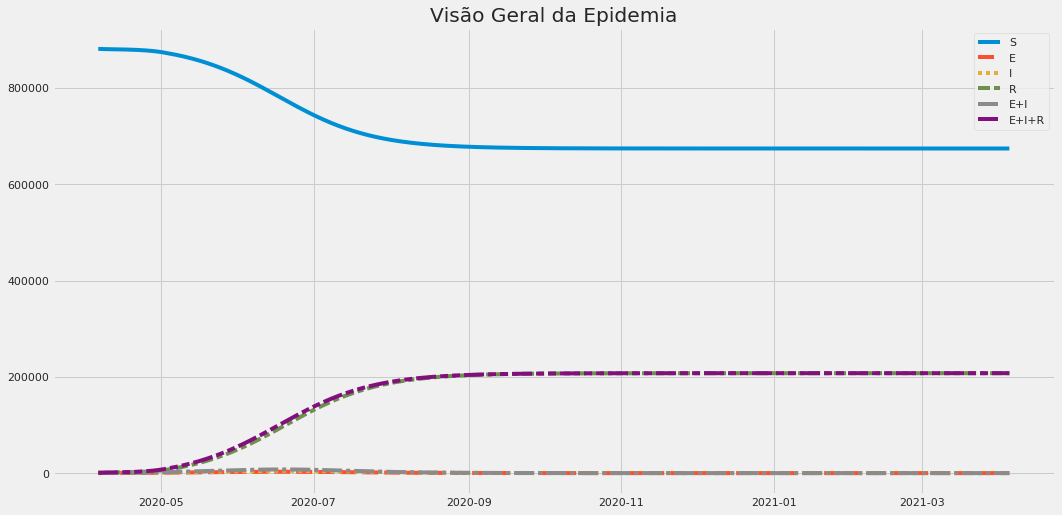

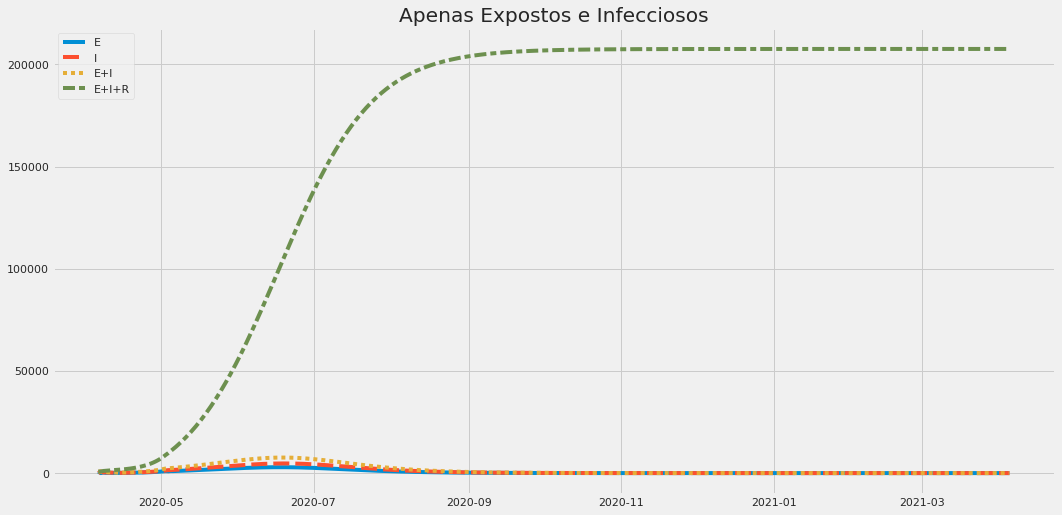

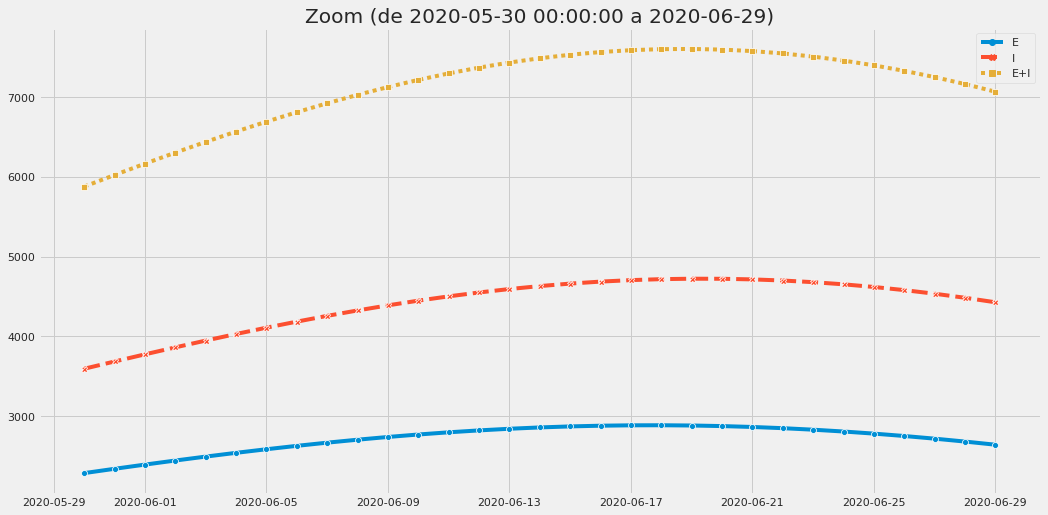

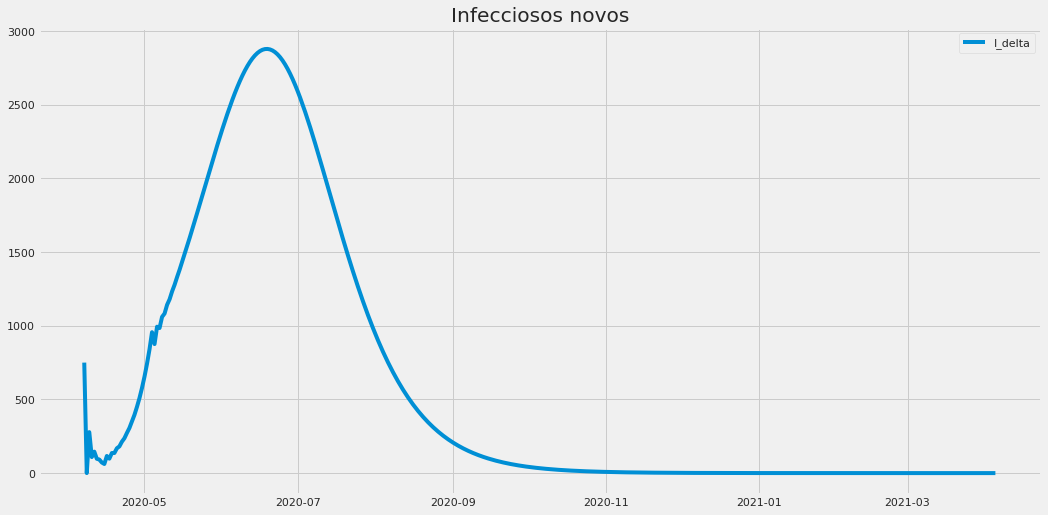

<Figure size 1152x576 with 0 Axes>

In [55]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [56]:
best['beta_3'] / best['gamma_1']

1.1319824676938604

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

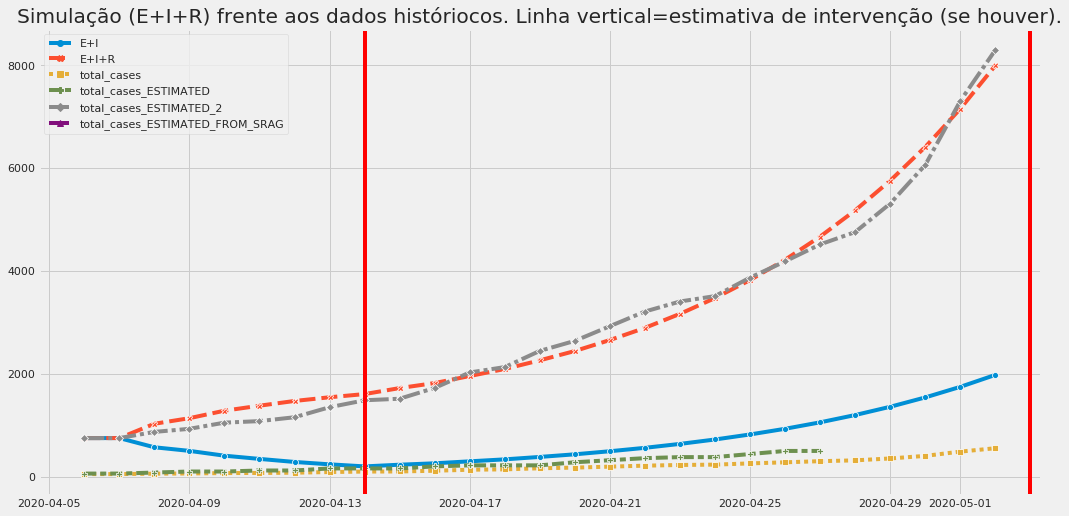

In [57]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

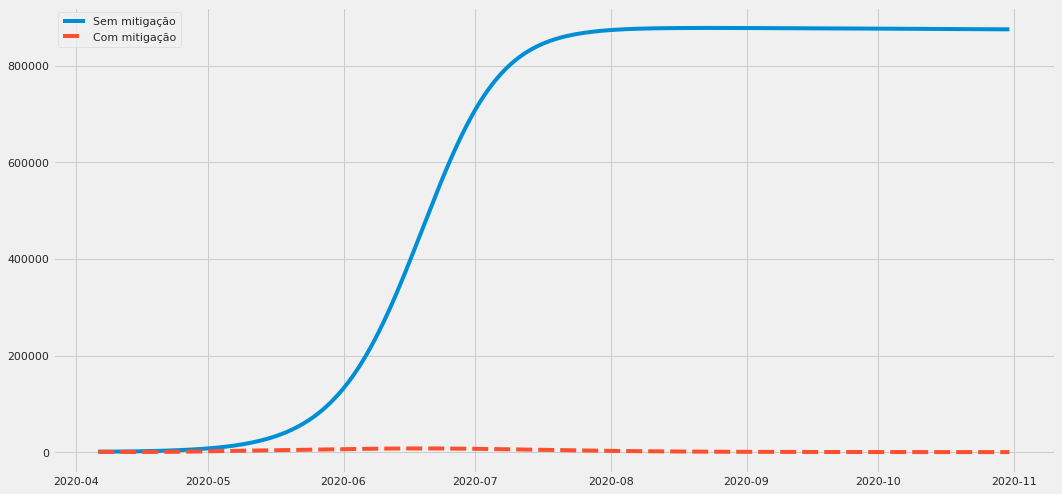

In [58]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [59]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [60]:
len(df_data_target)

29

In [61]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    for t in range(7, len(df_data_target), 1):
        print(f'###### t={t} ######')
        #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}

        t_2 = 10 if t >= 15.0 else 0.1
        t_3 = 10 if t >= 20.0 else 0.1

        ## assuming different gammas
        #
        #space = \
        #    {'dynamic':\
        #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
        #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
        #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
        #        0, t)
        #    }

        # assuming gamma_1 == gamma_2 == gamma_3
        space = \
            {'dynamic':\
                ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
                   'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
                   'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
                   {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
                 {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
                0, t)
            }

        trials = hyperopt.Trials()
        best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

        print("Best parameters found:", best)

        alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                    (best['alpha_2'], best['duration_2']),
                                    (best['alpha_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
        beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                    (best['beta_2'], best['duration_2']),
                                    (best['beta_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
       #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
       #                            (best['gamma_2'], best['duration_2']),
       #                            (best['gamma_3'], best['duration_3'])],
       #                            min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                    (best['gamma_1'], best['duration_2']),
                                    (best['gamma_1'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)

        r0_1 = best['beta_1'] / best['gamma_1']
        r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
        r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']

        r0s.append((r0_1, r0_2, r0_3))
        print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')


        df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=0, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)

        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [62]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame(r0s)
    df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)

In [63]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

In [64]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 25:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [65]:
if run_sensitivity_analysis:
    palette = sns.color_palette("coolwarm", len(df.columns))
    ax = sns.lineplot(data=df, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [66]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.